#### Notes
- DATASET: Customer-level data of a leading telecom firm, 
    - Data spans over four consecutive months - June, July, August and September. 
    - First 2 months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.
- GOAL: Identify customers at high risk of churn and identify the main indicators of churn.
- Business objective: Predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. To do this task well, understanding the typical customer behaviour during churn will be helpful.

In this project 
- it is primarliy Indian and Southeast Asian market.
- the usage-based definition is used to define churn.
- High-value customers are defined - who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase) = 29.9k rows
- Predict churn only on high-value customers.

### Strategy followed for analysis & model building
| | Step |  Status| Notes |
|---|---|---|---|
|1. | Read & filter data |  | |
|| &emsp;Filter high-value customers | Done |  |
|| &emsp;Tag churners | Done | |
|2. | Pre-process data | | |
|| &emsp;Handle invalid & missing values | Done | |
|| &emsp;Explore data | Done | |
|| &emsp;Remove attributes of the churn phase | Done | |
|| &emsp;Impute Missing value | Done | |
|| &emsp;Derive new features | Done | |
|| &emsp;Handle Outliers | Done | |
|| &emsp;Create Dummy variables | Todo | |
|3. | Prepare Data for model building | | |
|| &emsp;Test train split | Done | |
|| &emsp;Scale numerical values | Done | |
|| &emsp;Perform Dimensionality reduction (PCA) | Done| |
|| &emsp;Handle class imbalance | Done | |
|4.| Build model to predict customers who will churn  - with PCA | | Logistic Regression ,XGBoost , Randon Fores -should we use scaled data her ????? |
|| &emsp;Build model and evaluate | | |
|| &emsp;Use Regularization | | |
|| &emsp;Model evaluation | | |
|| &emsp;Interpretation of the model | | |
|5.| Build model to identify indicators of churn  - w/o PCA | | Logistic regression or a model from the tree family |
|| &emsp;Build model and evaluate | Done | |
|| &emsp;Model evaluation | Done | |
|| &emsp;Interpretation of the model | Done | |
|6.| Recommend strategies to manage customer churn | Done | |
|| &emsp;| | |
|| | | |

#### Hints
- Using techniques to handle class imbalance - class weights, stratify
- In case of logistic regression, make sure to handle multi-collinearity.

### Imports & Functions

In [ ]:
import sys

import numpy as np
import pandas as pd
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

# For data processing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

#### General functions

In [ ]:
# Calculates and returns the percentage of a value in the total
def percent(value, total):
    return round(100 * value/total, 2)  

# Display the len and columns of the df
def listColumns(df):
    print(f"{len(df.columns.tolist())} {df.columns.tolist()}")

# Get the columns with the specified prefix
def getColumnsWithPrefix(prefix, cols):
    lenPrefix = len(prefix)
    l =list(filter(lambda x: True if x[:lenPrefix]==prefix else False,cols))
    print(len(l), l)
    return l

# Get the columns with the specified suffix
def getColumnsWithSuffix(suffix,cols):
    lenSuffix = len(suffix)
    l =list(filter(lambda x: True if x[-1 * lenSuffix:]==suffix else False,cols))
    print(len(l), l)
    return l

def dropColumns(df_, coldesc, cols):
    print(f"Drop {coldesc} {len(cols)} columns: Shape {df_.shape}", end='')
    df_.drop(columns = cols, inplace=True)
    df_.reset_index(drop=True, inplace=True)
    print(f" --> {df_.shape}")

def dropRows(df_, indesc, index):
    print(f"Drop {indesc} {len(index)} Rows: Shape {df_.shape}", end='')
    df_.drop(index, inplace=True)
    df_.reset_index(drop=True, inplace=True)
    print(f" --> {df_.shape}")

# Get the number and percent of duplicate rows in the column
def getDuplicateRows(df, col):
    duplcate_rows = df[df[col].duplicated()][col].shape[0]
    return duplcate_rows, percent(duplcate_rows, df.shape[0])
    
# Lists the columns with missing values - col name, absolute number and percentage of cells missing in the column. 
# The columns are sorted in descending order of the number of missing values.
def listColumsWithMissingData(df, LIMIT=0):
    naCols = len(df.columns[df.isna().any()])
    print(f"Columns with missing data: {naCols} {percent(naCols, len(df.columns))}%")
    cols = {}
    for col in df.columns:
        if df[col].isna().any():
            missing_count = df[col].isna().sum(),percent(df[col].isna().sum(),df.shape[0])
            #print(col, missing_count)
            if missing_count[1] < LIMIT: continue
            cols[col] = missing_count
    cols = sorted(cols.items(), key=lambda x: x[1][0], reverse=True)
    #[print(f"{col[0]:15}  {col[1][0]:7d} {col[1][1]}%") for col in cols ]
    return cols

# Displays the columns with missing data using msno matrix and bar
def displayColumnsWithMissingData(df_):
    plt.figure(figsize=(10, 6 ))
    msno.matrix(df_[df_.columns[df_.isnull().any()]]);plt.show()
    msno.bar(df_[df_.columns[df_.isnull().any()]]);plt.show()

# Gets the list of columns which are categorical in nature
def getCategoricalColumns(df):
    cat_columns_ = df.select_dtypes(include=['object']).columns.tolist()
    cat_columns = sorted(cat_columns_)
    print(f"Columns with categorical values {len(cat_columns)} --> {cat_columns}")
    return cat_columns_

# For each categorical column, 
# - prints all the unique values 
# - plots the distribution of values
def plotCategoricalVariables(df_, cat_columns, title):
    COLS = 4
    count = len(cat_columns)
    rows = count//COLS + 1
    print(count, rows)
    fig = plt.figure(figsize=(24, rows*4))
    for i in range(count):
        col = cat_columns[i]
        count_values = df_[col].unique().shape[0]
        print(f"{col:27} : [{count_values:2}] --> {sorted((df_[col].unique().tolist())) if np.NaN not in df_[col].unique().tolist() else (df_[col].unique().tolist())}")
        df__ = (df_[[col]].value_counts(normalize=True)*100)#.to_frame()
        #df__.reset_index(drop=True, inplace=True)
        #df__[col] = df__[col].astype(int)
        #print(df__.head())
        plt.subplot(rows, COLS, i+1);ax=df__.plot.bar();_ = plt.xticks(rotation=0); annotate(ax)
    fig.suptitle(title, fontsize=14)

# Gets the list of columns which are numerical in nature
def getNumericalColumns(df):
    num_columns_ = df.select_dtypes(include=[np.float, np.int64]).columns.tolist()
    num_columns_ = sorted(num_columns_)
    print(f"Columns with numerical values {len(num_columns_)} --> {num_columns_}")
    return num_columns_ 

# For each numerical column, 
# - prints all the unique values (if <30), else prints 10 values
# - plots the distribution of values - distplot (for columns with >30 unique values) or histplot (for columns with <30 unique values)
def plotNumericalVariables(df_, num_cols, title):
    COLS = 4
    count = len(num_cols)
    rows = count//COLS + 1
    print(count, rows)
    fig = plt.figure(figsize=(24, rows*4))
    for i in range(count):
        col = num_cols[i]
        count_values = df_[col].unique().shape[0]
        if count_values > 30:
            print(f"{col:26} : [{count_values:4}] --> {sorted(df[col].unique().tolist()[:10])}...{sorted(df[col].unique().tolist()[-10:])}") 
            #df_ = df[[col]].value_counts(normalize=True)*100; 
            plt.subplot(rows, COLS, i+1);sns.distplot(df_[col])
        else:
            print(f"{col:26} : [{count_values:4}] --> {sorted(df[col].unique().tolist())}") 
            #ax=df[col].plot.hist(weights=np.ones(df.shape[0]) / df.shape[0]);annotate(ax, title=col);plt.show()
            #df_ = df[[col]].value_counts(normalize=True)*100; 
            plt.subplot(rows, COLS, i+1);sns.histplot(data=df_[col])

    fig.suptitle(title, fontsize=14)

# Plot the box plots for the specified numerical columns
def plotBoxPlots(df_, num_cols):
    COLS = 6
    count = len(num_cols)
    rows = count//COLS + 1
    print(count, rows)
    fig = plt.figure(figsize=(24, rows*4))
    for i in range(count):
        col = num_cols[i]
        plt.subplot(rows, COLS, i+1);sns.boxplot(y=df_[col])

    fig.suptitle("", fontsize=14)

# Converts the category to a ordinal numerical label
def clategoryToOridnalLabel(X, cat):
    oe = preprocessing.OrdinalEncoder(categories=cat)
    oe.fit(X)
    print(oe.categories_)
    X1 = oe.transform(X)
    #print(X1[:5])
    return X1
    #print(oe.feature_names_in_)

# Creates dummies for categorical columns and returns the combined dataframe
# The categorical column should be dropped.
def addDummies(df, col, dropcat, df_out):
    print(f"[{col}] Before: {df_out.columns.shape[0]}", end=' ')
    temp = pd.get_dummies(df[col], prefix=col, drop_first=True)
    #df.drop(columns=[col], inplace=True)
    #temp = temp.drop([dropcat], 1)
    #Adding the results to the master dataframe
    df_out = pd.concat([df_out, temp], axis=1)
    print(f"After: {df_out.columns.shape[0]}", end=' ')
    print()
    return df_out

# Annotates the bars
def annotate(ax, title='', strformat='', divideby=1):
    # Annotate
    for p in ax.patches:
        # format(, '.1f')
        value = p.get_height()/divideby
        ax.annotate(f"{value:.1f}{strformat}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')
    ax.set_title(title)

#### For model builing

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import GridSearchCV, StratifiedKFold

import statsmodels.api as sm

#COLS_DROPPED = []
def runRFE(numFeatures, X, y):
    #global COLS_DROPPED
    #COLS_DROPPED = []
    
    lm = LogisticRegression(random_state=42)
    rfe = RFE(lm, numFeatures)
    rfe = rfe.fit(X,y)
    list(zip(X.columns, rfe.support_, rfe.ranking_))
    cols = X.columns[rfe.support_].tolist()
    print("Columns selected by RFE:", len(cols), cols)

    cols_dropped = list(set(X.columns)-set(cols))
    #COLS_DROPPED.extend(list(set(X.columns)-set(X.columns[rfe.support_].tolist())))
    print("Columns dropped by RFE:", len(cols_dropped), cols_dropped)

    return cols

# Build a  Linear Regression Model
def buildLogRegModel(X, y):
    X_sm = sm.add_constant(X)

    # create the model
    lr = sm.GLM(y, X_sm, family = sm.families.Binomial())
    lr_model = lr.fit()
    #print(lr_model.params)
    print(lr_model.summary())
    return lr_model, X_sm

# Calculate & print VIF
def getVIF(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by="VIF", ascending=False)
    print(vif)

# Drop one column from the current dataset and build the model. Store the dropped column in dropped_cols so that these can be dropped from the test dataset also
def dropColumnAndBuildModel(X, y, col=""):
    #global COLS_DROPPED
    print(len(X.columns))
    if col != "":  
        X.drop(columns=col, inplace=True)
        #COLS_DROPPED.append(col)
    lr_model, X_sm = buildLogRegModel(X, y)
    getVIF(X)
    return lr_model, X_sm

####  For model evaluation

In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score

DF_SUMMARY = pd.DataFrame(columns=['Category', 'Num Features', 'Features', 'Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'Recall', 'AUC'])
# Prints the following evaluation metrics of a classification model. 
# metrics: confusion_matrix, accuracy, sensitivity, specificity, FPR, PPV, plots ROC curve
#   category: 'TRAIN' or 'TEST'
#   y_actual, y_predicted: The actual target and predicted values
def evaluate_classification_model(category, features, y_actual, y_predicted):
    global DF_SUMMARY
    #y_predicted = classifier.predict(X)
    #print(f"{category} Accuracy : {percent(accuracy_score(y_actual, y_predicted), 1)}%")
    print(f"{category} Confusion Matrix:")
    confusion = confusion_matrix(y_actual, y_predicted)
    TP, TN,FP, FN  = confusion[1,1], confusion[0,0], confusion[0,1], confusion[1,0]
    print(f"TP: {TP}, TN: {TN}, FP:{FP}, FN:{FN}")
    print(confusion)
    
    sensitivity = TP/float (TP+FN); sensitivity=round(sensitivity*100,2)
    specificity = TN/float (TN+FP); specificity = round(specificity*100,2)
    fpr = FP/float(TN+FP); fpr = round(fpr*100,2)
    ppv = TP/float(TP+FP); ppv = round(ppv*100,2)

    accuracy    = round(100 * accuracy_score(y_actual, y_predicted),2)

    print(classification_report(y_actual, y_predicted))
    precision   = round(100 * metrics.precision_score(y_actual, y_predicted), 2)
    recall      = round(100 * metrics.recall_score(y_actual, y_predicted), 2)

    print(f"Accuracy: % {accuracy} Sensitivity: {sensitivity}% Specificity: {specificity}% Precision: {precision}% Recall: {recall}% FPR: {fpr}% PPV: {ppv}%")
    #print(f"Sensitivity: {round(sensitivity*100,2)}% Specificity: {round(specificity*100,2)}% FPR: {round(fpr*100,2)}% PPV: {round(ppv*100,2)}%")

    auc_score = round(100 * draw_roc(y_actual, y_predicted),2)

    metrics_ = {'Category': category, 'Num Features': len(features), 'Features': features, 'Accuracy': accuracy, 'Sensitivity': sensitivity, 'Specificity': specificity, 'Precision': precision, 'Recall': recall, 'AUC':auc_score }
    DF_SUMMARY = DF_SUMMARY.append(metrics_, ignore_index = True)
    return metrics_

# Calculate & print VIF
def getVIF(X_train):
    vif = pd.DataFrame()
    vif['Features'] = X_train.columns
    vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by="VIF", ascending=False)
    print(vif)

def draw_roc (actual,probs):
    fpr,tpr,_ = metrics.roc_curve (actual,probs,drop_intermediate = False)
    auc_score = metrics.roc_auc_score(actual,probs)
    plt.figure (figsize =(5,5))
    #plt.figure()
    plt.plot(fpr, tpr, label = 'ROC Curve(area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0]); plt.xlabel('False Positive Rate')
    plt.ylim([0.0, 1.05]); plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic - Lead Score')
    plt.legend(loc="lower right")

    plt.show()
    return auc_score

def predict(model, X, y, prob=0.5):
    y_pred = model.predict(X)
    #print(y_pred [:5])
    #print((y_pred*100).astype(int)[:5])

    y_pred = y_pred.values.reshape(-1)
    #print(y_pred[:5])

    y_pred_final = pd.DataFrame ({'Actual': y.values, 'Prob' : y_pred})
    y_pred_final['ID'] = y.index
    y_pred_final.index = y.index
    #print(y_pred_final.head())

    y_pred_final['Predicted'] = y_pred_final['Prob'].map(lambda x: 1 if x>prob else 0)

    ## LOOK at the head of the data
    print(y_pred_final.head())
    return y_pred_final

def predAndEvaluateForVariousCutoffs(y_pred):
    # Predict for various cut-offs 
    numbers = [float(x)/10 for x in range (10)]
    for i in numbers:
        y_pred[i] = y_pred['Prob'].map(lambda x: 1 if x>i else 0)

    # Calculate accuracy, sensitivity & specificity for probab cut offs
    cutoff_df = pd.DataFrame(columns=['prob','accuracy','sensi','speci'])
    for i in numbers:
        cm1 = metrics.confusion_matrix(y_pred['Actual'],y_pred[i])
        total1=sum(sum(cm1))
        accuracy = (cm1[0,0]+cm1[1,1])/total1
        speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        cutoff_df.loc[i] = [i,accuracy,sensi,speci]
    print(cutoff_df)

    # plot accuracy, sensitivity & specificity
    plt.figure(figsize=(10,10))
    cutoff_df.plot.line(x='prob',y=['accuracy','sensi','speci'])
    plt.show()
    return y_pred.head()

# Read & Filter data

In [8]:
from google.colab import files
uploaded = files.upload()

import io
df = pd.read_csv(io.BytesIO(uploaded['telecom_churn_data.csv']))

df.info()

Saving telecom_churn_data.csv to telecom_churn_data (1).csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [9]:
df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,...,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,...,150.76,109.61,0.00,212.17,212.17,212.17,NaN,212.17,212.17,212.17,NaN,0.0,0.0,0.0,NaN,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,355.074,268.321,86.285,24.11,78.68,7.68,18.34,15.74,99.84,304.76,53.76,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,23.88,74.56,7.68,18.34,11.51,75.94,291.86,53.76,0.00,0.00,0.00,...,0.00,0.00,0.00,NaN,0.00,0.00,NaN,NaN,28.61,7.60,NaN,NaN,0.0,0.0,NaN,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,189.058,210.226,290.714,11.54,55.24,37.26,74.81,143.33,220.59,208.36,118.91,0.0,0.00,0.00,38.49,0.0,0.00,0.00,70.94,7.19,28.74,13.58,14.39,29.34,16.86,38.46,28.16,24.11,21.79,15.61,...,0.00,0.00,8.42,NaN,NaN,NaN,2.84,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,251.102,508.054,389.500,99.91,54.39,310.98,241.71,123.31,109.01,71.68,113.54,0.0,54.86,44.38,0.00,0.0,28.09,39.04,0.00,73.68,34.81,10.61,15.49,107.43,83.21,22.46,65.46,1.91,0.65,4.91,...,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,309.876,238.174,163.426,50.31,149.44,83.89,58.78,76.96,91.88,124.26,45.81,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,50.31,149.44,83.89,58.78,67.64,91.88,124.26,37.89,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [10]:
listColumns(df)

226 ['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9', 'arpu_6', 'arpu_7', 'arpu_8', 'arpu_9', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'onnet_mou_9', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'offnet_mou_9', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_ic_mou_9', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'roam_og_mou_9', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_t2c_mou_9', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'loc_og_mou_9', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2t_mou_9', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m

Do we need to handle missing values for 
- PCA?
- decision trees/random forest? 

In [11]:
COLS= df.columns.tolist()
COLS_ID = ['mobile_number']
COLS_LOC = getColumnsWithPrefix('loc',COLS) # LOCAL
COLS_STD = getColumnsWithPrefix('std',COLS)
COLS_ISD = getColumnsWithPrefix('isd',COLS)
COLS_LAST_DATE = getColumnsWithPrefix('last_date_',COLS)
COLS_DATE = getColumnsWithPrefix('date_',COLS)
COLS_ARPU = getColumnsWithPrefix('arpu',COLS)
COLS_ONNET = getColumnsWithPrefix('onnet',COLS)
COLS_OFFNET = getColumnsWithPrefix('offnet',COLS)
COLS_ROAM = getColumnsWithPrefix('roam',COLS)
COLS_SPL = getColumnsWithPrefix('spl',COLS)
COLS_OG = getColumnsWithPrefix('og',COLS)
COLS_IC = getColumnsWithPrefix('ic',COLS)
COLS_TOTAL = getColumnsWithPrefix('total',COLS)
COLS_MAX = getColumnsWithPrefix('max',COLS)
COLS_COUNT = getColumnsWithPrefix('count',COLS)
COLS_AV = getColumnsWithPrefix('av',COLS)
COLS_VOL = getColumnsWithPrefix('vol',COLS)
COLS_NIGHT = getColumnsWithPrefix('night',COLS)
COLS_MONTH = getColumnsWithPrefix('monthly',COLS)
COLS_SACHET = getColumnsWithPrefix('sachet',COLS)
COLS_FB = getColumnsWithPrefix('fb_user',COLS)
COLS_4_MON = getColumnsWithPrefix('jun',COLS) + getColumnsWithPrefix('jul',COLS) + getColumnsWithPrefix('aug',COLS) + getColumnsWithPrefix('sep',COLS)

38 ['loc_og_t2o_mou', 'loc_ic_t2o_mou', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_t2c_mou_9', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'loc_og_mou_9', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'loc_ic_t2f_mou_9', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'loc_ic_mou_9']
41 ['std_og_t2o_mou', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2t_mou_9', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2m_mou_9', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_t2f_mou_9', 'std_og_t2

In [12]:
df[COLS_LAST_DATE].head()

,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9
0,6/30/2014,7/31/2014,8/31/2014,9/30/2014
1,6/30/2014,7/31/2014,8/31/2014,9/30/2014
2,6/30/2014,7/31/2014,8/31/2014,9/30/2014
3,6/30/2014,7/31/2014,8/31/2014,9/30/2014
4,6/30/2014,7/31/2014,8/31/2014,9/30/2014


In [13]:
df[COLS_DATE].head()

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9
0,6/21/2014,7/16/2014,8/8/2014,9/28/2014,6/21/2014,7/16/2014,8/8/2014,NaN
1,6/29/2014,7/31/2014,8/28/2014,9/30/2014,NaN,7/25/2014,8/10/2014,NaN
2,6/17/2014,7/24/2014,8/14/2014,9/29/2014,NaN,NaN,NaN,9/17/2014
3,6/28/2014,7/31/2014,8/31/2014,9/30/2014,NaN,NaN,NaN,NaN
4,6/26/2014,7/28/2014,8/9/2014,9/28/2014,6/4/2014,NaN,NaN,NaN


In [14]:
COLS_CAT = getCategoricalColumns(df)

Columns with categorical values 12 --> ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_9', 'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8', 'date_of_last_rech_data_9', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9']


In [15]:
df[COLS_CAT].head()

,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9
0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/21/2014,7/16/2014,8/8/2014,9/28/2014,6/21/2014,7/16/2014,8/8/2014,NaN
1,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/29/2014,7/31/2014,8/28/2014,9/30/2014,NaN,7/25/2014,8/10/2014,NaN
2,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/17/2014,7/24/2014,8/14/2014,9/29/2014,NaN,NaN,NaN,9/17/2014
3,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/28/2014,7/31/2014,8/31/2014,9/30/2014,NaN,NaN,NaN,NaN
4,6/30/2014,7/31/2014,8/31/2014,9/30/2014,6/26/2014,7/28/2014,8/9/2014,9/28/2014,6/4/2014,NaN,NaN,NaN


In [ ]:
COLS_NUM = getNumericalColumns(df)

Columns with numerical values 214 --> ['aon', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'arpu_2g_9', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_3g_9', 'arpu_6', 'arpu_7', 'arpu_8', 'arpu_9', 'aug_vbc_3g', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9', 'circle_id', 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_2g_9', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'count_rech_3g_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9', 'ic_others_6', 'ic_others_7', 'ic_others_8', 'ic_others_9', 'isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8', 'isd_ic_mou_9', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'isd_og_mou_9', 'jul_vbc_3g', 'jun_vbc_3g', 'last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8', 'last_day_rch_amt_9', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'loc_ic_mou_9', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'loc_ic_t2f_mou_9', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'lo

## Filter high value customers

```High-value customers``` are those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).
After filtering the high-value customers, you should get about 29.9k rows.

In [16]:
print(list(filter(lambda x: True if 'rech_amt' in x else False, COLS)))

['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'total_rech_amt_9', 'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'max_rech_amt_9', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9']


In [17]:
# The average recharge amount in the good phase (months 6 & 7) is in the columns 'total_rech_amt_6', 'total_rech_amt_7'. Check if there is missing data
df[['total_rech_amt_6', 'total_rech_amt_7']].isnull().sum()

total_rech_amt_6    0
total_rech_amt_7    0
dtype: int64

The  columns 'total_rech_amt_6', 'total_rech_amt_7' do not have any missing data. So we can proceed to calculate the high-value customers

In [18]:
# Store the average recharge amount in the good phase (months 6 & 7) in the column 'avg_rech_amt_67'
df['avg_rech_amt_67'] = (df['total_rech_amt_6'] + df['total_rech_amt_7'])/2
print("Average recharge amount:");print(df[['total_rech_amt_6', 'total_rech_amt_7', 'avg_rech_amt_67']].head())

# Calculate the 70th percentile of the average recharge amount in the good phase (months 6 & 7)
PC_70_AVG_RECH_AMT = df['avg_rech_amt_67'].quantile([.7]).values[0]; print('\nPC_70_AVG_RECH_AMT:', PC_70_AVG_RECH_AMT)

# Drop all the rows with avg_rech_amt_67 below 70th percentile. Retain only the high value customers
print("Number of rows > PC_70_AVG_RECH_AMT:", df[df['avg_rech_amt_67']>PC_70_AVG_RECH_AMT].shape[0])
print("Number of rows >= PC_70_AVG_RECH_AMT:", df[df['avg_rech_amt_67']>=PC_70_AVG_RECH_AMT].shape[0])
df = df[df['avg_rech_amt_67']>=PC_70_AVG_RECH_AMT]
print("Number of rows retained in df:", df.shape[0])

Average recharge amount:
   total_rech_amt_6  total_rech_amt_7  avg_rech_amt_67
0               362               252            307.0
1                74               384            229.0
2               168               315            241.5
3               230               310            270.0
4               196               350            273.0

PC_70_AVG_RECH_AMT: 368.5
Number of rows > PC_70_AVG_RECH_AMT: 29979
Number of rows >= PC_70_AVG_RECH_AMT: 30011
Number of rows retained in df: 30011


In [19]:
df.shape

(30011, 227)

## Tag the churners

Step1: Tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are: total_ic_mou_9, total_og_mou_9, vol_2g_mb_9, vol_3g_mb_9

Step2: After tagging churners, remove all the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names).

In [20]:
COLS_USAGE = ['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9']
print(df[COLS_USAGE].shape[0])
print(df[COLS_USAGE].isnull().sum())

30011
total_ic_mou_9    0
total_og_mou_9    0
vol_2g_mb_9       0
vol_3g_mb_9       0
dtype: int64


None of the columns needed to tag having data. So we can proceed without further processing

In [21]:
# Find the number of rows where each of the columns are 0
df[df['total_ic_mou_9']==0].shape[0], df[df['total_og_mou_9']==0].shape[0],df[df['vol_2g_mb_9']==0].shape[0], df[df['vol_3g_mb_9']==0].shape[0]

(2941, 3249, 20698, 22824)

In [22]:
# Find all the rows where the churn columns are 0 - no calls & no mobile internet usage
CHURN_CONDITION = (df['total_ic_mou_9']==0) & (df['total_og_mou_9']==0) & (df['vol_2g_mb_9']==0) & (df['vol_3g_mb_9']==0)
df[CHURN_CONDITION].shape[0]

2593

In [23]:
# Tag the customers with all churn columns 0 - no calls & no mobile internet usage
COL_TARGET = 'churn'
print("Columns:", len(df.columns.tolist()), end=' --> ')
df[COL_TARGET] = 0
df.loc[CHURN_CONDITION, 'churn'] = 1

Columns: 227 --> 

NOTE: We will do the step2 (remove the columns of month 9) after exploring how the customer behaviour is across various phases

In [24]:
print(len(df.columns.tolist())); print((100*df[COL_TARGET].value_counts(normalize=True)).round(2))

228
0    91.36
1     8.64
Name: churn, dtype: float64


The target variable ```churn``` is imbalanced with 91% no churn and 9% churn data points.

|   | | Predicted|  |
|---|---|---|---|
||   | 0  | 1  |
| Actual | 0 | TN   | FP  |
| | 1 |  FN |  TP |

- **False Positive (FP)**: Predicted "Churn" but was "No Churn"
- **False Negative (FN)**: Predicted "No Churn" but was "Churn" --> We would like this to be as low as possible because lot of genuine high value customers who could churn will not be addressed 

So, the evaluation metric for the classification models would be **Recall**=TP/(TP+FN)


In [25]:
df.shape

(30011, 228)

# Pre-process Data

## Handle invalid & missing values

### Identify columns with missing data

<Figure size 720x432 with 0 Axes>

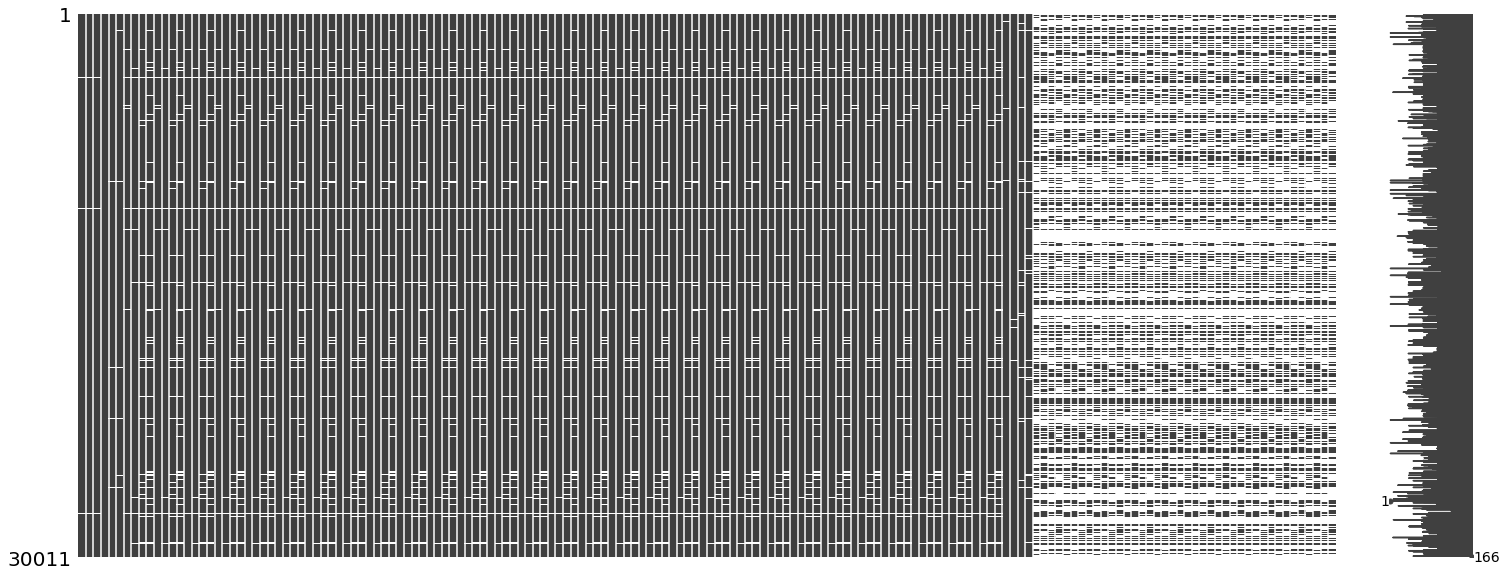

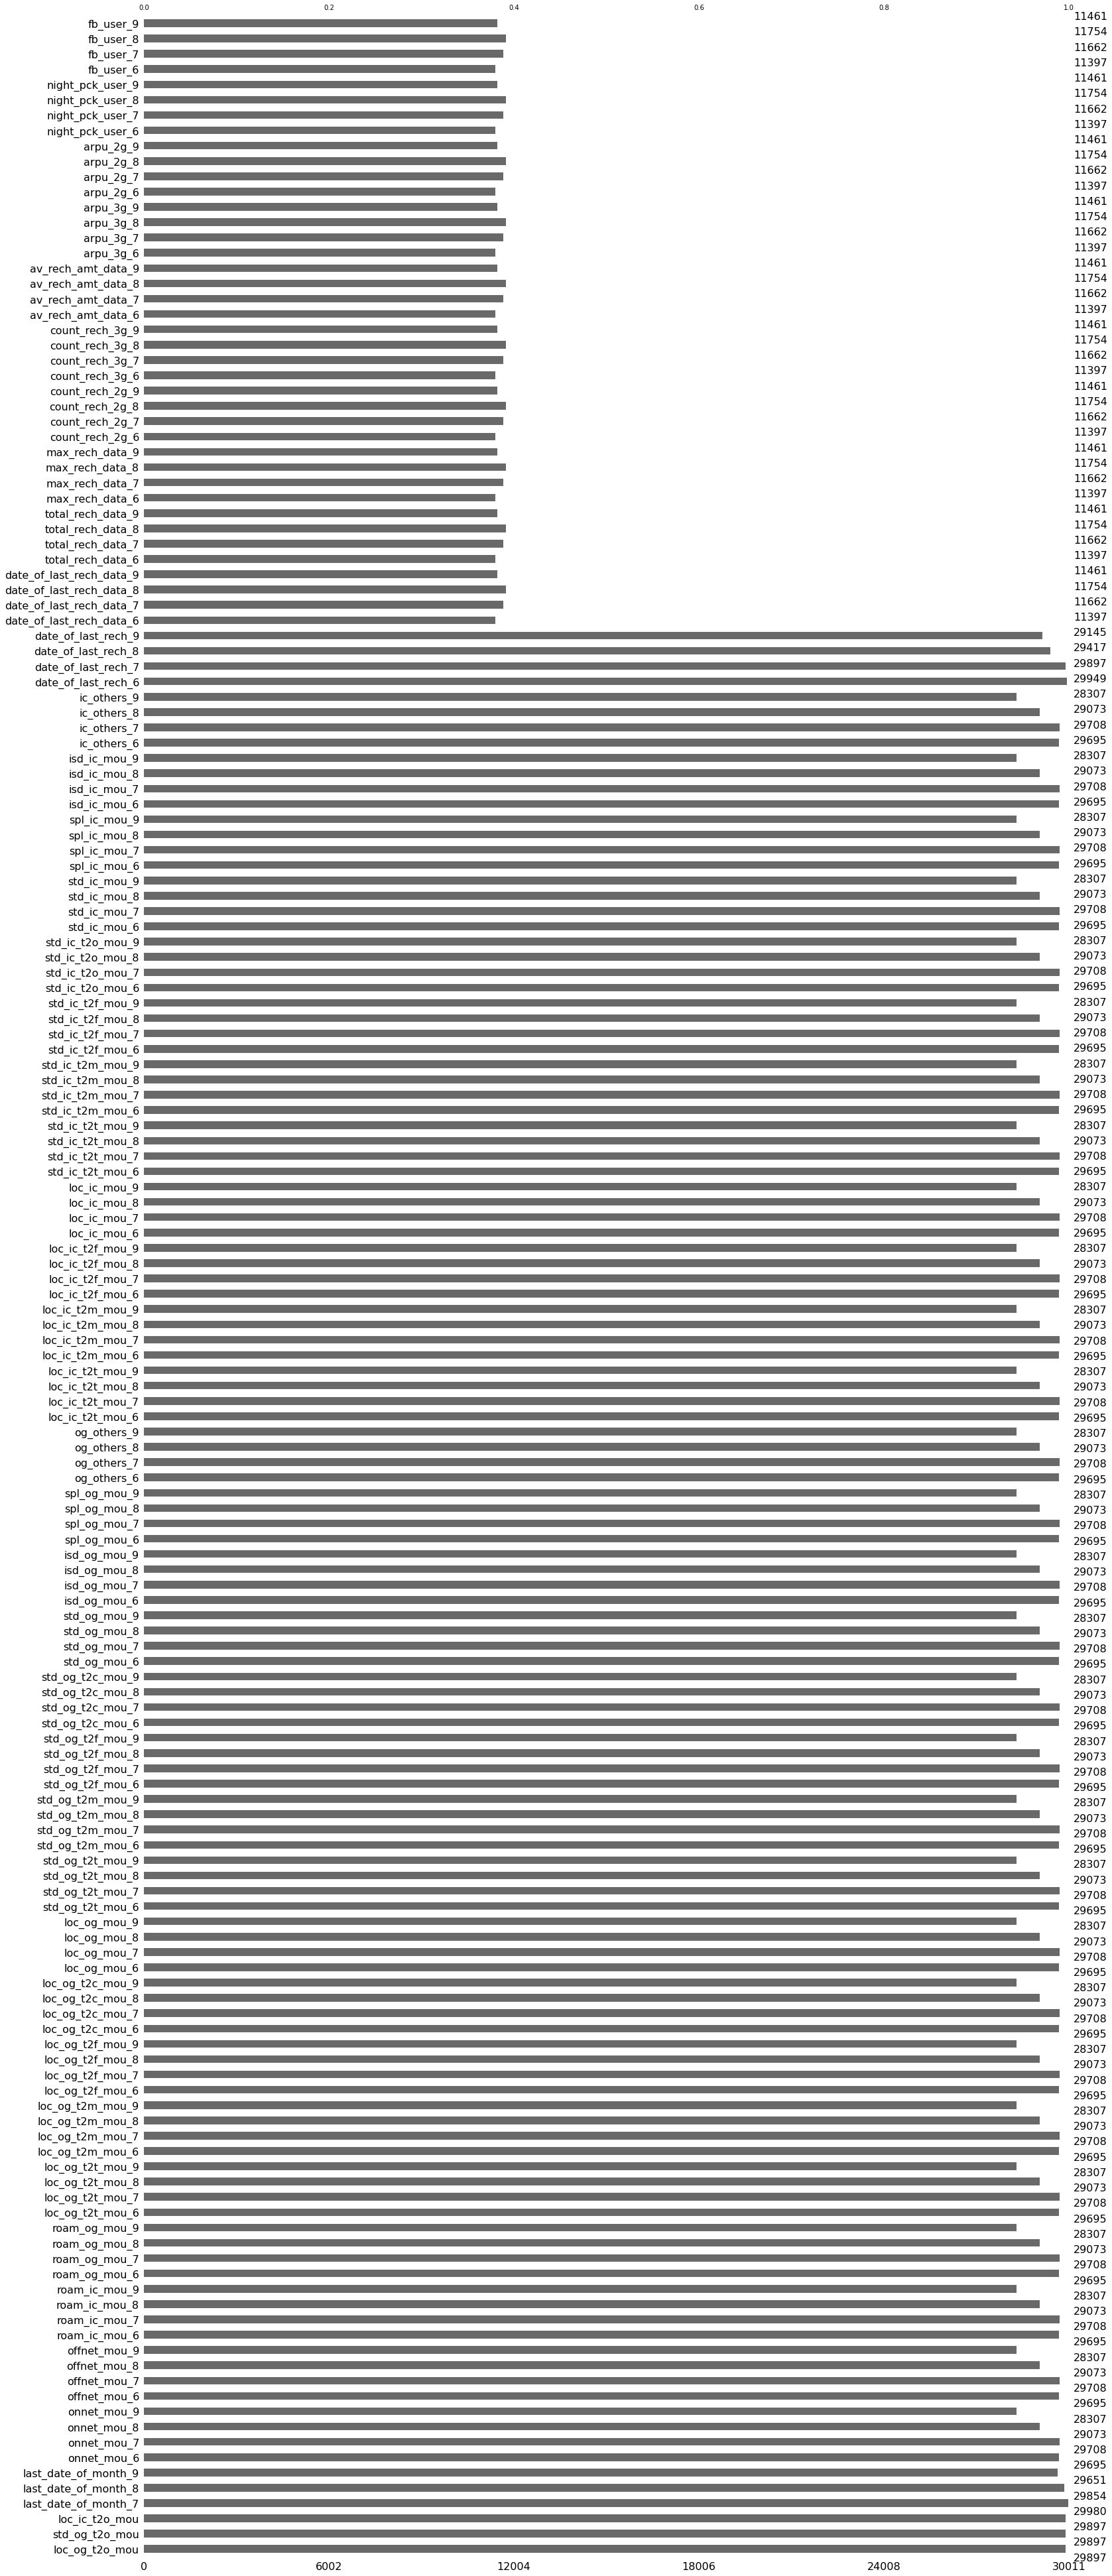

Columns with missing data: 166 72.81%


[('date_of_last_rech_data_6', (18614, 62.02)),
 ('total_rech_data_6', (18614, 62.02)),
 ('max_rech_data_6', (18614, 62.02)),
 ('count_rech_2g_6', (18614, 62.02)),
 ('count_rech_3g_6', (18614, 62.02)),
 ('av_rech_amt_data_6', (18614, 62.02)),
 ('arpu_3g_6', (18614, 62.02)),
 ('arpu_2g_6', (18614, 62.02)),
 ('night_pck_user_6', (18614, 62.02)),
 ('fb_user_6', (18614, 62.02)),
 ('date_of_last_rech_data_9', (18550, 61.81)),
 ('total_rech_data_9', (18550, 61.81)),
 ('max_rech_data_9', (18550, 61.81)),
 ('count_rech_2g_9', (18550, 61.81)),
 ('count_rech_3g_9', (18550, 61.81)),
 ('av_rech_amt_data_9', (18550, 61.81)),
 ('arpu_3g_9', (18550, 61.81)),
 ('arpu_2g_9', (18550, 61.81)),
 ('night_pck_user_9', (18550, 61.81)),
 ('fb_user_9', (18550, 61.81)),
 ('date_of_last_rech_data_7', (18349, 61.14)),
 ('total_rech_data_7', (18349, 61.14)),
 ('max_rech_data_7', (18349, 61.14)),
 ('count_rech_2g_7', (18349, 61.14)),
 ('count_rech_3g_7', (18349, 61.14)),
 ('av_rech_amt_data_7', (18349, 61.14)),
 ('a

In [26]:
displayColumnsWithMissingData(df)
listColumsWithMissingData(df)

In [27]:
cols_miss_ = listColumsWithMissingData(df, 40)
cols_miss = [col[0] for col in cols_miss_]
print("Columns with more than 40% missing data:", cols_miss)#;[print(col, end=', ') for col in COLS_MISS]; print()

Columns with missing data: 166 72.81%
Columns with more than 40% missing data: ['date_of_last_rech_data_6', 'total_rech_data_6', 'max_rech_data_6', 'count_rech_2g_6', 'count_rech_3g_6', 'av_rech_amt_data_6', 'arpu_3g_6', 'arpu_2g_6', 'night_pck_user_6', 'fb_user_6', 'date_of_last_rech_data_9', 'total_rech_data_9', 'max_rech_data_9', 'count_rech_2g_9', 'count_rech_3g_9', 'av_rech_amt_data_9', 'arpu_3g_9', 'arpu_2g_9', 'night_pck_user_9', 'fb_user_9', 'date_of_last_rech_data_7', 'total_rech_data_7', 'max_rech_data_7', 'count_rech_2g_7', 'count_rech_3g_7', 'av_rech_amt_data_7', 'arpu_3g_7', 'arpu_2g_7', 'night_pck_user_7', 'fb_user_7', 'date_of_last_rech_data_8', 'total_rech_data_8', 'max_rech_data_8', 'count_rech_2g_8', 'count_rech_3g_8', 'av_rech_amt_data_8', 'arpu_3g_8', 'arpu_2g_8', 'night_pck_user_8', 'fb_user_8']


We should drop all these columns. Let's add the columns to drop to COLS_TO_DROP

In [28]:
COLS_TO_DROP = cols_miss

### Identify columns of Id type and with all same value

In [29]:
for col in COLS_CAT:
    duplicate_rows_num, duplicate_rows_pc = getDuplicateRows(df,col)
    print(f"{col}: Duplicates {duplicate_rows_num}, {duplicate_rows_pc} Unique values: {df[col].value_counts(normalize=True).shape[0]}")

last_date_of_month_6: Duplicates 30010, 100.0 Unique values: 1
last_date_of_month_7: Duplicates 30009, 99.99 Unique values: 1
last_date_of_month_8: Duplicates 30009, 99.99 Unique values: 1
last_date_of_month_9: Duplicates 30009, 99.99 Unique values: 1
date_of_last_rech_6: Duplicates 29980, 99.9 Unique values: 30
date_of_last_rech_7: Duplicates 29979, 99.89 Unique values: 31
date_of_last_rech_8: Duplicates 29979, 99.89 Unique values: 31
date_of_last_rech_9: Duplicates 29980, 99.9 Unique values: 30
date_of_last_rech_data_6: Duplicates 29980, 99.9 Unique values: 30
date_of_last_rech_data_7: Duplicates 29979, 99.89 Unique values: 31
date_of_last_rech_data_8: Duplicates 29979, 99.89 Unique values: 31
date_of_last_rech_data_9: Duplicates 29980, 99.9 Unique values: 30


In [30]:
print("Duplicates in mobile_number:", getDuplicateRows(df, 'mobile_number'))
print("Duplicates in circle_id:", getDuplicateRows(df, 'circle_id'))

Duplicates in mobile_number: (0, 0.0)
Duplicates in circle_id: (30010, 100.0)


In [31]:
cols_all_same_value = []
cols_less_unique_values = []
cols_all_unique = []
for col in COLS:
    duplicate_rows_num, duplicate_rows_pc = getDuplicateRows(df,col)
    unique_values = df[col].value_counts().index.tolist()
    unique_rows_num = len(unique_values) #df[col].value_counts(normalize=True).shape[0]
    if unique_rows_num == 1:
        print(f"{col}: Duplicates {duplicate_rows_num}, {duplicate_rows_pc} Unique values: {unique_rows_num} ")
        cols_all_same_value.append(col)
    elif duplicate_rows_num == 0:
        cols_all_unique.append(col)
    elif unique_rows_num < 3:
        print(f"{col}: Duplicates {duplicate_rows_num}, {duplicate_rows_pc} Unique values: {unique_rows_num} {unique_values}")
        cols_less_unique_values.append(col)
    #print(f"{col}: Duplicates {duplicate_rows_num}, {duplicate_rows_pc} Unique values: {df[col].value_counts(normalize=True).shape[0]}")

print();print('COLS_ALL_UNIQUE', cols_all_unique)
print('COLS_ALL_SAME_VALUE', cols_all_same_value)
print('COLS_LESS_UNIQUE_VALUES', cols_less_unique_values)

circle_id: Duplicates 30010, 100.0 Unique values: 1 
loc_og_t2o_mou: Duplicates 30009, 99.99 Unique values: 1 
std_og_t2o_mou: Duplicates 30009, 99.99 Unique values: 1 
loc_ic_t2o_mou: Duplicates 30009, 99.99 Unique values: 1 
last_date_of_month_6: Duplicates 30010, 100.0 Unique values: 1 
last_date_of_month_7: Duplicates 30009, 99.99 Unique values: 1 
last_date_of_month_8: Duplicates 30009, 99.99 Unique values: 1 
last_date_of_month_9: Duplicates 30009, 99.99 Unique values: 1 
std_og_t2c_mou_6: Duplicates 30009, 99.99 Unique values: 1 
std_og_t2c_mou_7: Duplicates 30009, 99.99 Unique values: 1 
std_og_t2c_mou_8: Duplicates 30009, 99.99 Unique values: 1 
std_og_t2c_mou_9: Duplicates 30009, 99.99 Unique values: 1 
std_ic_t2o_mou_6: Duplicates 30009, 99.99 Unique values: 1 
std_ic_t2o_mou_7: Duplicates 30009, 99.99 Unique values: 1 
std_ic_t2o_mou_8: Duplicates 30009, 99.99 Unique values: 1 
std_ic_t2o_mou_9: Duplicates 30009, 99.99 Unique values: 1 
night_pck_user_6: Duplicates 30008, 9

- Mobile number is unique for all rows. This should be dropped for model building.
- As all the rows for the COLS_ALL_SAME_VALUE columns have the same value. We can drop these.
Let's append these to the COLS_TO_DROP

In [32]:
print("Before: ", len(COLS_TO_DROP), COLS_TO_DROP)
COLS_TO_DROP.extend(cols_all_same_value)
COLS_TO_DROP.extend(cols_all_unique)
print();print("After: ", len(COLS_TO_DROP), COLS_TO_DROP)

Before:  40 ['date_of_last_rech_data_6', 'total_rech_data_6', 'max_rech_data_6', 'count_rech_2g_6', 'count_rech_3g_6', 'av_rech_amt_data_6', 'arpu_3g_6', 'arpu_2g_6', 'night_pck_user_6', 'fb_user_6', 'date_of_last_rech_data_9', 'total_rech_data_9', 'max_rech_data_9', 'count_rech_2g_9', 'count_rech_3g_9', 'av_rech_amt_data_9', 'arpu_3g_9', 'arpu_2g_9', 'night_pck_user_9', 'fb_user_9', 'date_of_last_rech_data_7', 'total_rech_data_7', 'max_rech_data_7', 'count_rech_2g_7', 'count_rech_3g_7', 'av_rech_amt_data_7', 'arpu_3g_7', 'arpu_2g_7', 'night_pck_user_7', 'fb_user_7', 'date_of_last_rech_data_8', 'total_rech_data_8', 'max_rech_data_8', 'count_rech_2g_8', 'count_rech_3g_8', 'av_rech_amt_data_8', 'arpu_3g_8', 'arpu_2g_8', 'night_pck_user_8', 'fb_user_8']

After:  57 ['date_of_last_rech_data_6', 'total_rech_data_6', 'max_rech_data_6', 'count_rech_2g_6', 'count_rech_3g_6', 'av_rech_amt_data_6', 'arpu_3g_6', 'arpu_2g_6', 'night_pck_user_6', 'fb_user_6', 'date_of_last_rech_data_9', 'total_rech

### Handle Missing data

Drop the columns in COLS_TO_DROP - columns with 
- > 40% missing data
- all same data
- all unique data

In [33]:
dropColumns(df, "COLS_TO_DROP", COLS_TO_DROP)

Drop COLS_TO_DROP 57 columns: Shape (30011, 228) --> (30011, 171)


Drop rows with > 80% missing data

In [34]:
df_row_gt_80_miss = df[df.isna().sum(axis="columns") > 80]
df_row_gt_80_miss.shape[0], 100 * df_row_gt_80_miss.shape[0]/df.shape[0]

(254, 0.8463563360101296)

There are 254 rows i.e. <1% rows with > 80% data missing. Let's drop this

In [35]:
dropRows(df, "ROWS > 80", df_row_gt_80_miss.index)

Drop ROWS > 80 254 Rows: Shape (30011, 171) --> (29757, 171)


<Figure size 720x432 with 0 Axes>

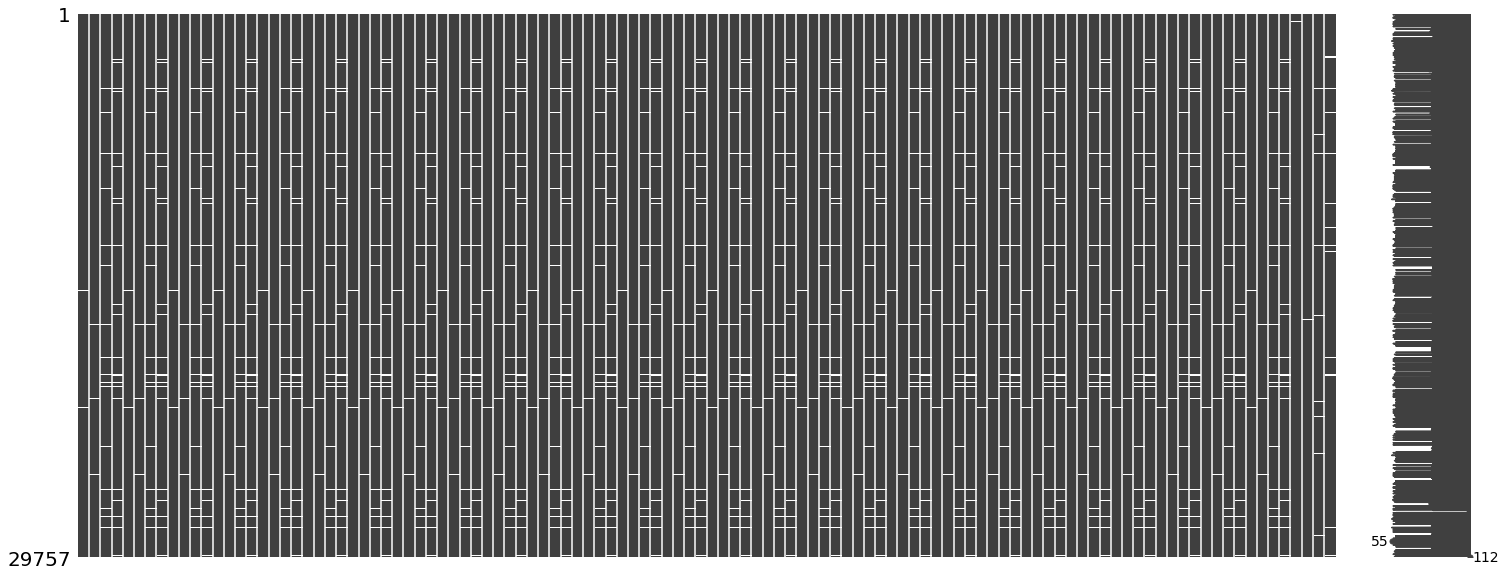

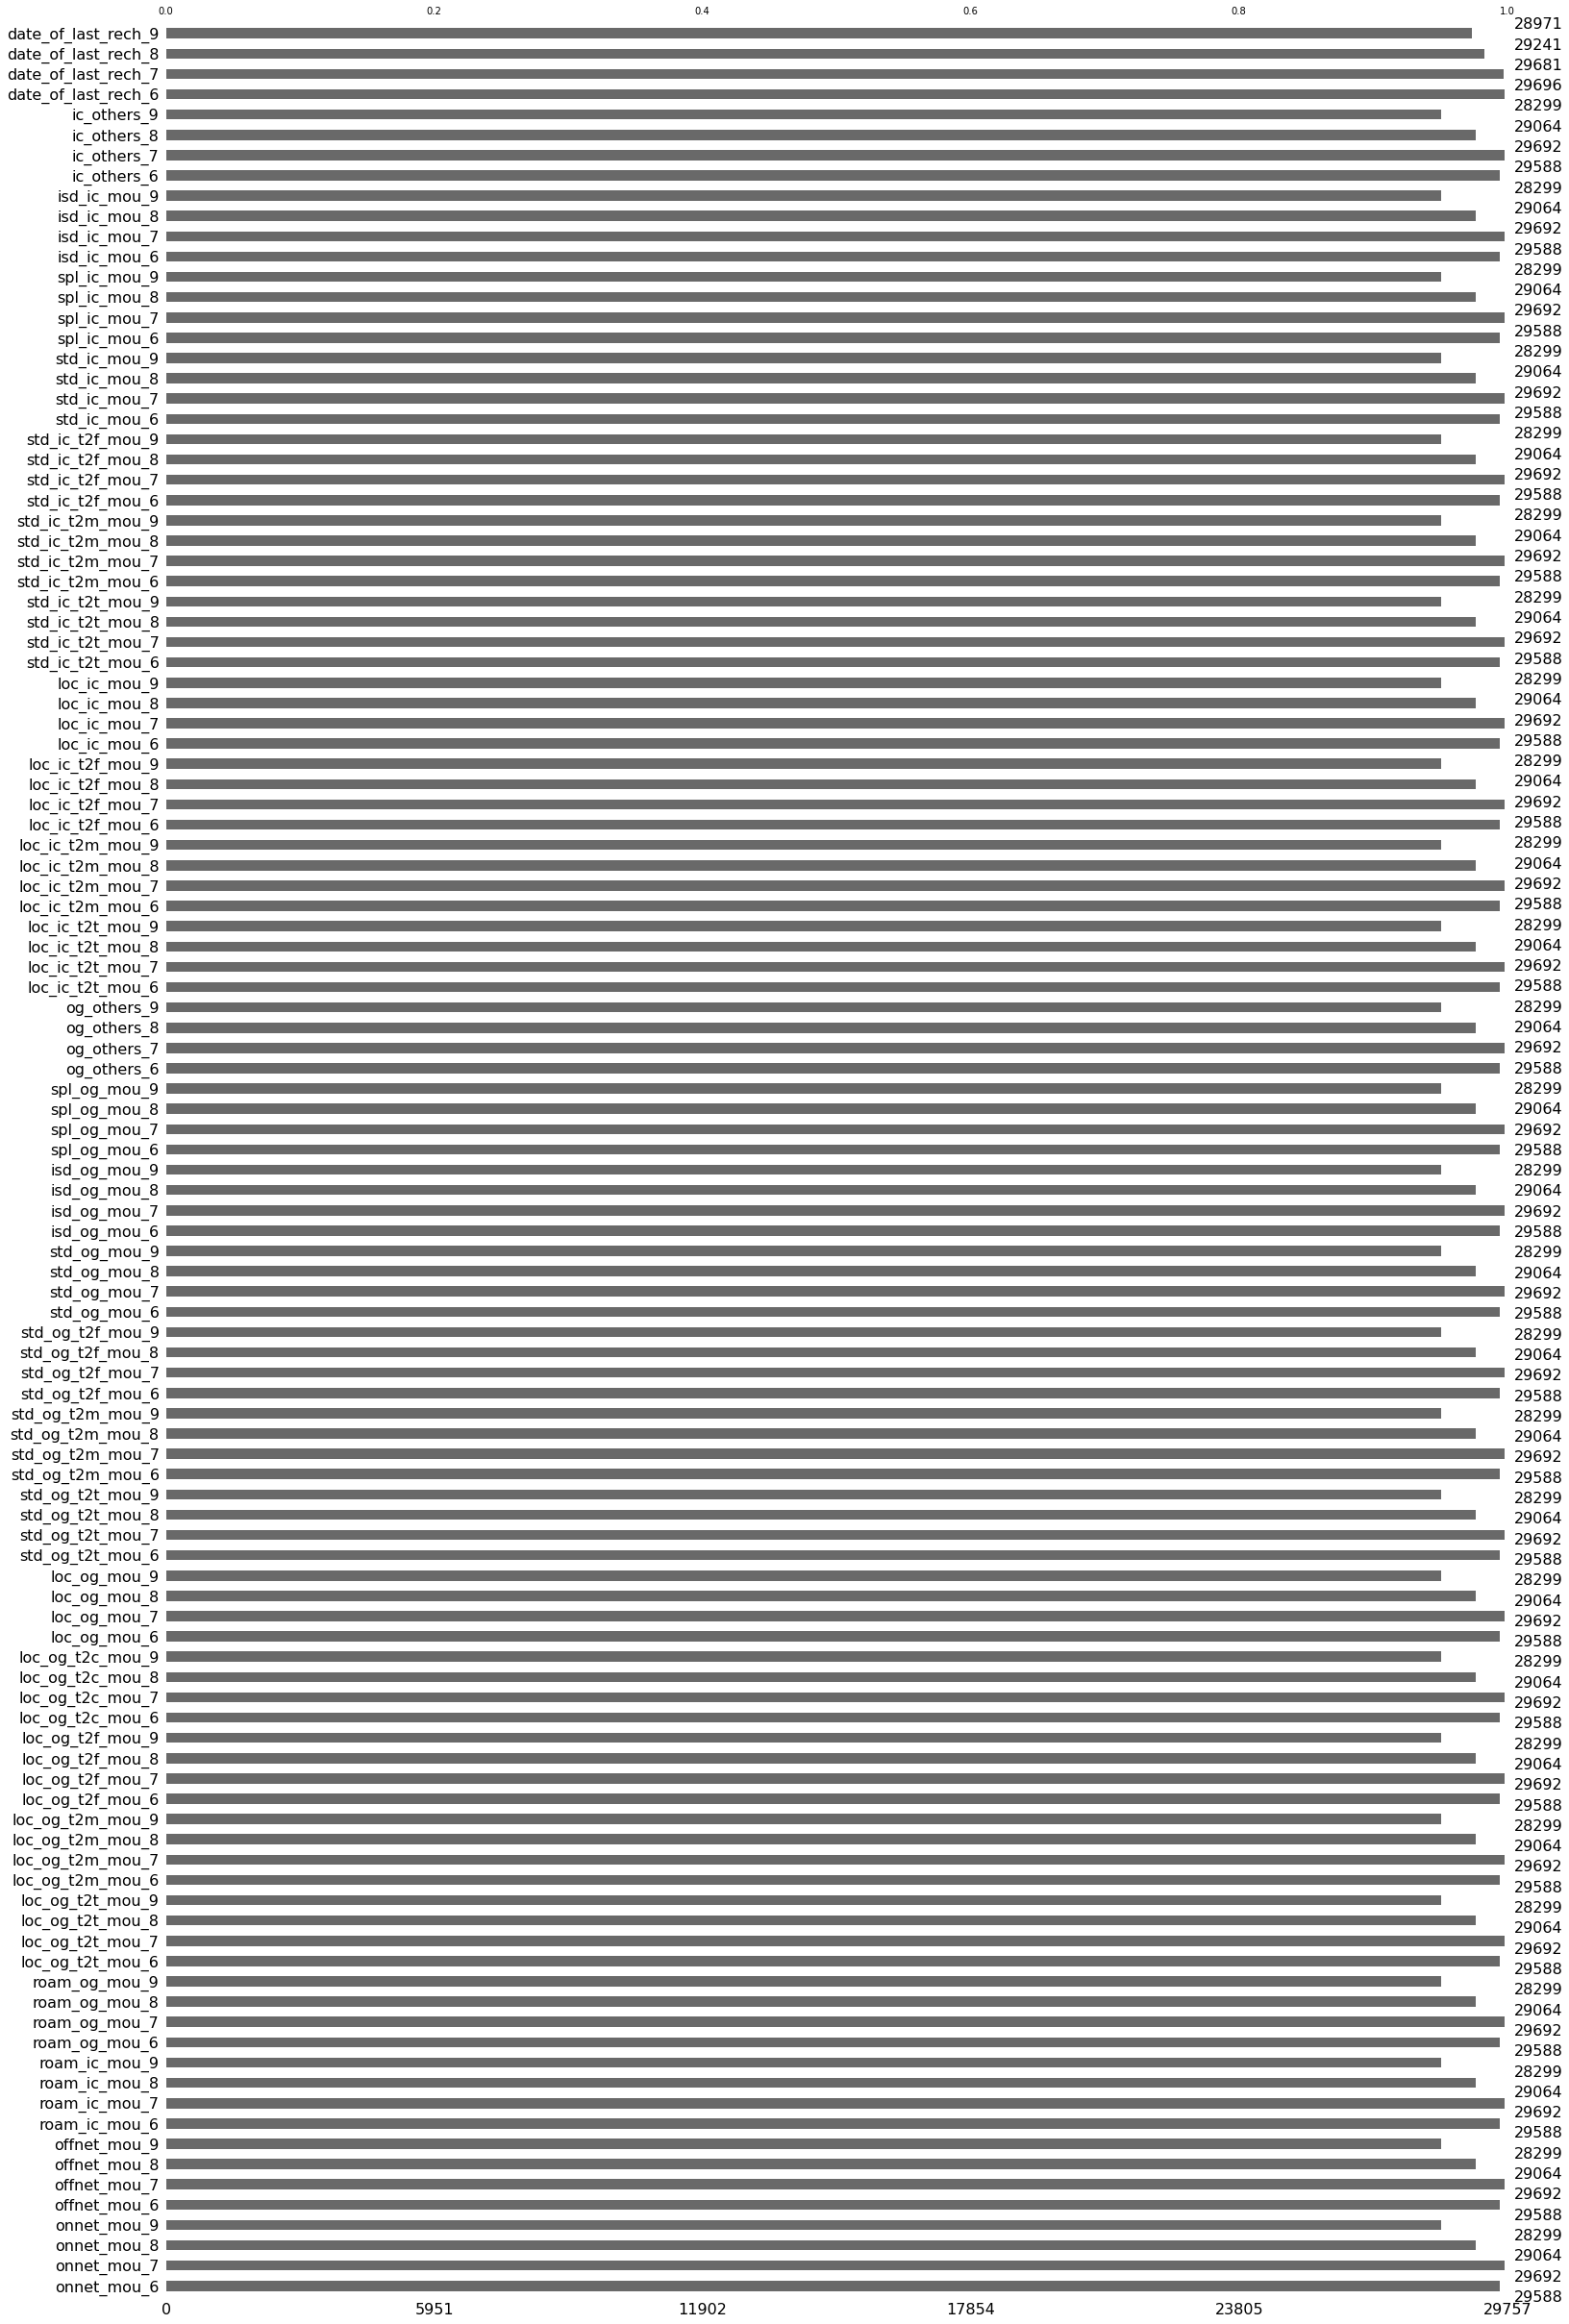

Columns with missing data: 112 65.5%
onnet_mou_9, offnet_mou_9, roam_ic_mou_9, roam_og_mou_9, loc_og_t2t_mou_9, loc_og_t2m_mou_9, loc_og_t2f_mou_9, loc_og_t2c_mou_9, loc_og_mou_9, std_og_t2t_mou_9, std_og_t2m_mou_9, std_og_t2f_mou_9, std_og_mou_9, isd_og_mou_9, spl_og_mou_9, og_others_9, loc_ic_t2t_mou_9, loc_ic_t2m_mou_9, loc_ic_t2f_mou_9, loc_ic_mou_9, std_ic_t2t_mou_9, std_ic_t2m_mou_9, std_ic_t2f_mou_9, std_ic_mou_9, spl_ic_mou_9, isd_ic_mou_9, ic_others_9, date_of_last_rech_9, onnet_mou_8, offnet_mou_8, roam_ic_mou_8, roam_og_mou_8, loc_og_t2t_mou_8, loc_og_t2m_mou_8, loc_og_t2f_mou_8, loc_og_t2c_mou_8, loc_og_mou_8, std_og_t2t_mou_8, std_og_t2m_mou_8, std_og_t2f_mou_8, std_og_mou_8, isd_og_mou_8, spl_og_mou_8, og_others_8, loc_ic_t2t_mou_8, loc_ic_t2m_mou_8, loc_ic_t2f_mou_8, loc_ic_mou_8, std_ic_t2t_mou_8, std_ic_t2m_mou_8, std_ic_t2f_mou_8, std_ic_mou_8, spl_ic_mou_8, isd_ic_mou_8, ic_others_8, date_of_last_rech_8, onnet_mou_6, offnet_mou_6, roam_ic_mou_6, roam_og_mou_6, loc_og

[('onnet_mou_9', (1458, 4.9)),
 ('offnet_mou_9', (1458, 4.9)),
 ('roam_ic_mou_9', (1458, 4.9)),
 ('roam_og_mou_9', (1458, 4.9)),
 ('loc_og_t2t_mou_9', (1458, 4.9)),
 ('loc_og_t2m_mou_9', (1458, 4.9)),
 ('loc_og_t2f_mou_9', (1458, 4.9)),
 ('loc_og_t2c_mou_9', (1458, 4.9)),
 ('loc_og_mou_9', (1458, 4.9)),
 ('std_og_t2t_mou_9', (1458, 4.9)),
 ('std_og_t2m_mou_9', (1458, 4.9)),
 ('std_og_t2f_mou_9', (1458, 4.9)),
 ('std_og_mou_9', (1458, 4.9)),
 ('isd_og_mou_9', (1458, 4.9)),
 ('spl_og_mou_9', (1458, 4.9)),
 ('og_others_9', (1458, 4.9)),
 ('loc_ic_t2t_mou_9', (1458, 4.9)),
 ('loc_ic_t2m_mou_9', (1458, 4.9)),
 ('loc_ic_t2f_mou_9', (1458, 4.9)),
 ('loc_ic_mou_9', (1458, 4.9)),
 ('std_ic_t2t_mou_9', (1458, 4.9)),
 ('std_ic_t2m_mou_9', (1458, 4.9)),
 ('std_ic_t2f_mou_9', (1458, 4.9)),
 ('std_ic_mou_9', (1458, 4.9)),
 ('spl_ic_mou_9', (1458, 4.9)),
 ('isd_ic_mou_9', (1458, 4.9)),
 ('ic_others_9', (1458, 4.9)),
 ('date_of_last_rech_9', (786, 2.64)),
 ('onnet_mou_8', (693, 2.33)),
 ('offnet_mou_8

In [36]:
displayColumnsWithMissingData(df)
cols_miss = listColumsWithMissingData(df, 0)
[print(col[0], end=', ') for col in cols_miss];print()
cols_miss

There is still missing data. But the missing data is < 5%. Let us explore the data and decide how to impute this missing data

## Explore

Let's see how the usage and revenue patterns differ between the customers who churn and who do not.

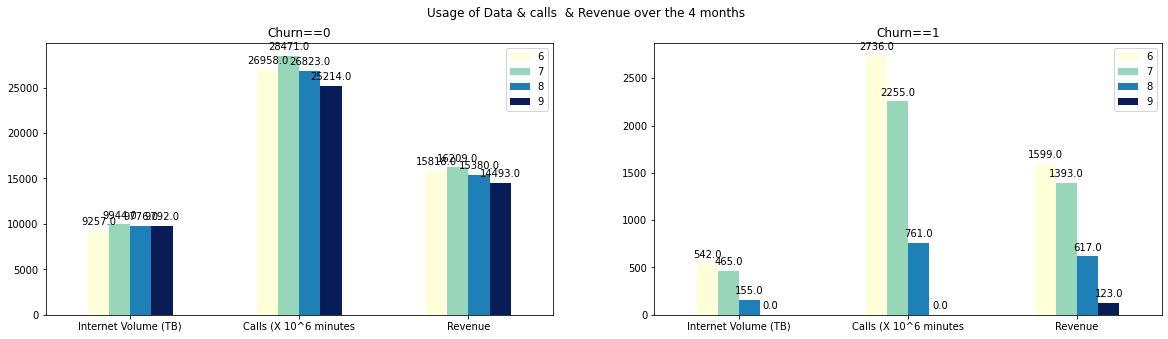

In [37]:
cols_ = ['vol_2g_mb', 'vol_3g_mb', 'total_ic_mou', 'total_og_mou', 'arpu']

df_0 = pd.DataFrame(columns=cols_) 
df_1 = pd.DataFrame(columns=cols_)
for mon in [6, 7, 8, 9]:
    for col in cols_:
        #print(mon, f'{col}_{mon}', int(df[f'{col}_{mon}'].sum()))
        df_0.loc[f'{mon}', col] = int(df[df['churn']==0][f'{col}_{mon}'].sum()/1000)
        df_1.loc[f'{mon}', col] = int(df[df['churn']==1][f'{col}_{mon}'].sum()/1000)


LABELS_USAGE_REVENUE = ['Internet Volume (TB)', 'Calls (X 10^6 minutes', 'Revenue']
df_0['Internet Volume (TB)'] = df_0['vol_2g_mb']+df_0['vol_3g_mb']
df_0['Calls (X 10^6 minutes'] = df_0['total_ic_mou']+df_0['total_og_mou']
df_0.rename(columns={'arpu':'Revenue'}, inplace=True)
df_0 = df_0[LABELS_USAGE_REVENUE].transpose()

df_1['Internet Volume (TB)'] = df_1['vol_2g_mb']+df_1['vol_3g_mb']
df_1['Calls (X 10^6 minutes'] = df_1['total_ic_mou']+df_1['total_og_mou']
df_1.rename(columns={'arpu':'Revenue'}, inplace=True)
df_1 = df_1[LABELS_USAGE_REVENUE].transpose()

fig = plt.figure(figsize=(20,5)); fig.suptitle("Usage of Data & calls  & Revenue over the 4 months")
ax = plt.subplot(1,2,1); ax = df_0.plot.bar(cmap='YlGnBu', ax=ax); annotate(ax, title="Churn==0"); ax.set_xticklabels(LABELS_USAGE_REVENUE, rotation=0)
ax = plt.subplot(1,2,2); ax = df_1.plot.bar(cmap='YlGnBu', ax=ax); annotate(ax, title="Churn==1"); ax.set_xticklabels(LABELS_USAGE_REVENUE, rotation=0)
print()

We can see that the usage and revenue falls drastically in the case of churn == 1. We can have the diff in usage and revenue as new features.

Let's see how the ```age on the network - number of days the customer is using the operator T network ```differs for customers who churn and who do not.

df_0 27327
df_1 2430



Text(0.5, 1.0, 'churn==1')

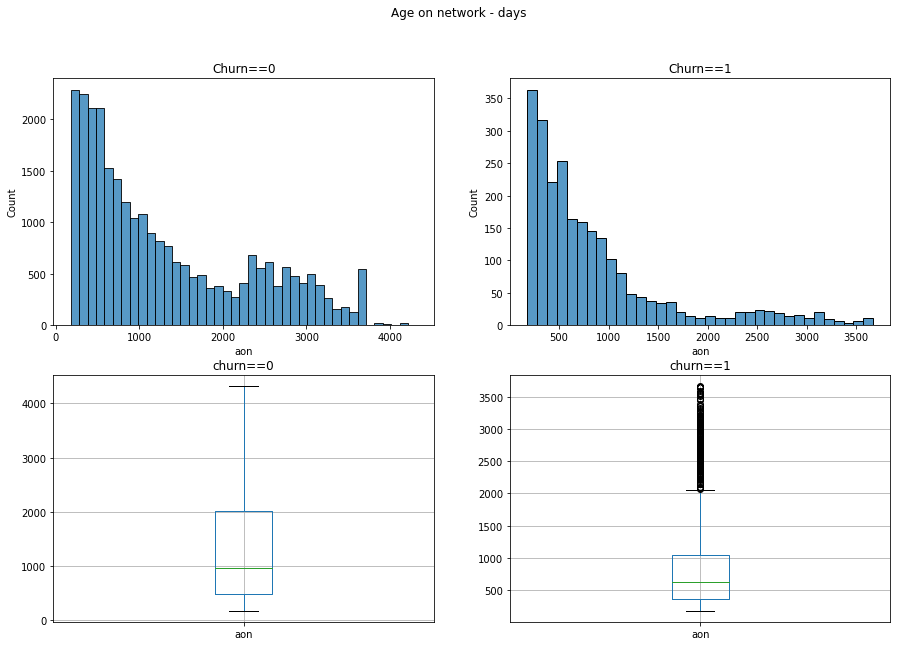

In [38]:
df_0 = df[df['churn']==0];print('df_0', df_0.shape[0])
df_1 = df[df['churn']==1];print('df_1', df_1.shape[0])

plt.figure(figsize=(15,10));plt.suptitle('Age on network - days')
ax = plt.subplot(2,2,1);sns.histplot(df_0, x='aon',ax=ax);ax.set_title("Churn==0")
ax = plt.subplot(2,2,2);sns.histplot(df_1, x='aon',ax=ax);ax.set_title("Churn==1"); print()

ax = plt.subplot(2,2,3);df_0.boxplot(column='aon', ax=ax); ax.set_title("churn==0")
ax = plt.subplot(2,2,4);df_1.boxplot(column='aon', ax=ax); ax.set_title("churn==1")

- Customers who do not churn have a typical aon - age on network of 1000 days
- Customers who churn have a typical on - age on network of 600 days

### Understand the groups of columns - ```Temporary```

In [39]:
listColumns(df)

171 ['arpu_6', 'arpu_7', 'arpu_8', 'arpu_9', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'onnet_mou_9', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'offnet_mou_9', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_ic_mou_9', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'roam_og_mou_9', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_t2c_mou_9', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'loc_og_mou_9', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2t_mou_9', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2m_mou_9', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_t2f_mou_9', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'std_og_mou_9', 'isd_og

In [40]:
cols_imp = ['loc_ic_mou_6', 'loc_og_mou_6', 'std_ic_mou_6', 'std_og_mou_6','isd_ic_mou_6','isd_og_mou_6','spl_ic_mou_6', 'spl_og_mou_6', 'ic_others_6', 'og_others_6','roam_ic_mou_6',
'roam_og_mou_6', 'onnet_mou_6',  'offnet_mou_6', 'vol_2g_mb_6', 'vol_3g_mb_6', 'total_ic_mou_6',  'total_og_mou_6','arpu_6']
len(cols_imp)

19

In [41]:
COLS_NOT_PRESENT = []
for col in [
    'loc_ic_mou_6', 
'loc_ic_t2t_mou_6', 
'loc_ic_t2m_mou_6', 
'loc_ic_t2f_mou_6', 

'loc_og_mou_6', 
'loc_og_t2t_mou_6',
'loc_og_t2m_mou_6',
'loc_og_t2f_mou_6', 
'loc_og_t2c_mou_6', 

'std_ic_mou_6', 
'std_ic_t2t_mou_6',
'std_ic_t2m_mou_6', 
'std_ic_t2f_mou_6',
'std_ic_t2o_mou_6', 

'std_og_mou_6',
'std_og_t2t_mou_6', 
'std_og_t2m_mou_6',
'std_og_t2f_mou_6', 
'std_og_t2c_mou_6', 

'isd_ic_mou_6',
'isd_og_mou_6',

'spl_ic_mou_6', 
'spl_og_mou_6', 

'ic_others_6', 
'og_others_6',

'roam_ic_mou_6',
'roam_og_mou_6',
 
'onnet_mou_6', 
'offnet_mou_6', 

'count_rech_2g_6',
'count_rech_3g_6',

'total_rech_num_6',
'total_rech_amt_6', 
'total_rech_data_6', 

'max_rech_amt_6', 
'max_rech_data_6', 

'av_rech_amt_data_6', 

'date_of_last_rech_6',  
'date_of_last_rech_data_6', 
'last_day_rch_amt_6',  
'last_date_of_month_6', 

'vol_2g_mb_6',
'vol_3g_mb_6',

'total_ic_mou_6', 
'total_og_mou_6',

'arpu_6', 

'sachet_2g_6', 
'sachet_3g_6',
'monthly_2g_6',
'monthly_3g_6', 
'night_pck_user_6', ]:
    if col not in df.columns:
        COLS_NOT_PRESENT.append(col[:-1])
        print(col)
print(COLS_NOT_PRESENT)

std_ic_t2o_mou_6
std_og_t2c_mou_6
count_rech_2g_6
count_rech_3g_6
total_rech_data_6
max_rech_data_6
av_rech_amt_data_6
date_of_last_rech_data_6
last_date_of_month_6
night_pck_user_6
['std_ic_t2o_mou_', 'std_og_t2c_mou_', 'count_rech_2g_', 'count_rech_3g_', 'total_rech_data_', 'max_rech_data_', 'av_rech_amt_data_', 'date_of_last_rech_data_', 'last_date_of_month_', 'night_pck_user_']


In [42]:
COLS = df.columns
for col in COLS_NOT_PRESENT:
    for mon in [6, 7, 8, 9]:
        col_mon = f"{col}{mon}"
        if col_mon not in COLS:
            print(col_mon)

std_ic_t2o_mou_6
std_ic_t2o_mou_7
std_ic_t2o_mou_8
std_ic_t2o_mou_9
std_og_t2c_mou_6
std_og_t2c_mou_7
std_og_t2c_mou_8
std_og_t2c_mou_9
count_rech_2g_6
count_rech_2g_7
count_rech_2g_8
count_rech_2g_9
count_rech_3g_6
count_rech_3g_7
count_rech_3g_8
count_rech_3g_9
total_rech_data_6
total_rech_data_7
total_rech_data_8
total_rech_data_9
max_rech_data_6
max_rech_data_7
max_rech_data_8
max_rech_data_9
av_rech_amt_data_6
av_rech_amt_data_7
av_rech_amt_data_8
av_rech_amt_data_9
date_of_last_rech_data_6
date_of_last_rech_data_7
date_of_last_rech_data_8
date_of_last_rech_data_9
last_date_of_month_6
last_date_of_month_7
last_date_of_month_8
last_date_of_month_9
night_pck_user_6
night_pck_user_7
night_pck_user_8
night_pck_user_9


'loc_ic_mou_6', 
'loc_ic_t2t_mou_6', 
'loc_ic_t2m_mou_6', 
'loc_ic_t2f_mou_6', 

'loc_og_mou_6', 
'loc_og_t2t_mou_6',
'loc_og_t2m_mou_6',
'loc_og_t2f_mou_6', 
'loc_og_t2c_mou_6', 

'std_ic_mou_6', 
'std_ic_t2t_mou_6'
'std_ic_t2m_mou_6', 
'std_ic_t2f_mou_6', 

'std_og_mou_6',
'std_og_t2t_mou_6', 
'std_og_t2m_mou_6',
'std_og_t2f_mou_6', 

'isd_ic_mou_6',
'isd_og_mou_6',

'spl_ic_mou_6', 
'spl_og_mou_6', 

'ic_others_6', 
'og_others_6',

'roam_ic_mou_6',
'roam_og_mou_6',
 
'onnet_mou_6', 
'offnet_mou_6', 

'total_rech_num_6',
'total_rech_amt_6', 

'max_rech_amt_6', 

'date_of_last_rech_6',  
'last_day_rch_amt_6',  

'vol_2g_mb_6',
'vol_3g_mb_6',

'total_ic_mou_6', 
'total_og_mou_6',

'arpu_6', 

'sachet_2g_6', 
'sachet_3g_6'
'monthly_2g_6',
'monthly_3g_6', 

In [43]:
COL_SCHEME = ['sachet_2g_6', 'sachet_3g_6','monthly_2g_6','monthly_3g_6']
print(100 * df[COL_SCHEME].isnull().sum()/df.shape[0])
for col in COL_SCHEME:
    print(col, len(df[col].unique()), df[col].unique())
df[COL_SCHEME].tail()

sachet_2g_6     0.0
sachet_3g_6     0.0
monthly_2g_6    0.0
monthly_3g_6    0.0
dtype: float64
sachet_2g_6 30 [ 0  4  1  3  7 12  5  2  6 10  8 16  9 19 11 22 14 20 13 17 18 25 21 32
 15 39 24 27 30 34]
sachet_3g_6 25 [ 0  1  3  8  2 10  5  4 13  7  6 29 16 18 12 11  9 23 14 19 15 21 22 17
 28]
monthly_2g_6 5 [0 2 1 3 4]
monthly_3g_6 12 [ 0  4  2  1  3  5  7  6  9  8 11 14]


,sachet_2g_6,sachet_3g_6,monthly_2g_6,monthly_3g_6
29752,1,0,0,0
29753,0,0,0,0
29754,1,0,0,0
29755,0,0,0,0
29756,1,1,0,1


In [44]:
for col in ['date_of_last_rech_6', 'last_day_rch_amt_6', ]:
    print(col, len(df[col].unique()))

date_of_last_rech_6 31
last_day_rch_amt_6 157


In [45]:
print(sorted(df['last_day_rch_amt_6'].unique().tolist()))
print(sorted(df['last_day_rch_amt_7'].unique().tolist()))

[0, 5, 7, 9, 10, 12, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 52, 54, 55, 56, 58, 59, 60, 62, 65, 67, 68, 70, 75, 76, 77, 78, 86, 89, 90, 91, 95, 97, 98, 99, 100, 101, 102, 104, 107, 110, 116, 120, 125, 128, 145, 150, 152, 153, 154, 155, 169, 175, 179, 180, 194, 195, 198, 200, 201, 202, 215, 220, 225, 229, 230, 236, 250, 252, 269, 274, 279, 297, 300, 319, 325, 330, 339, 350, 351, 379, 390, 398, 399, 400, 410, 440, 455, 459, 500, 505, 550, 565, 599, 619, 650, 655, 750, 752, 755, 779, 790, 849, 855, 887, 951, 1000, 1001, 1010, 1050, 1098, 1100, 1255, 1479, 1500, 1555, 1580, 1649, 2000, 2010, 2100, 2199, 2933, 3010, 3100, 3299, 3350, 4010]
[0, 1, 4, 7, 9, 10, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 40, 41, 43, 44, 46, 47, 48, 49, 50, 52, 54, 55, 56, 58, 59, 60, 62, 65, 66, 67, 68, 70, 75, 77, 78, 86, 90, 91, 95, 97, 98, 99, 100, 101, 102, 107, 108, 110

In [46]:
# 'total_ic_mou_6',
COLS_IC = ['loc_ic_mou_6', 'std_ic_mou_6', 'isd_ic_mou_6','spl_ic_mou_6', 'roam_ic_mou_6']#,'ic_others_6']
df_ = df[COLS_IC+['total_ic_mou_6']].copy()
df_['total_ic'] = df_[COLS_IC].sum(axis=1)
df_.head()

,loc_ic_mou_6,std_ic_mou_6,isd_ic_mou_6,spl_ic_mou_6,roam_ic_mou_6,total_ic_mou_6,total_ic
0,427.88,180.54,2.06,0.21,16.23,626.46,626.92
1,81.43,22.43,0.00,0.00,0.00,103.86,103.86
2,215.58,423.81,245.28,0.45,23.53,968.61,908.65
3,276.86,87.99,0.00,0.00,0.00,364.86,364.85
4,81.96,9.91,0.00,0.00,0.00,91.88,91.87


In [47]:
COLS_OG = ['loc_og_mou_6', 'std_og_mou_6', 'isd_og_mou_6','spl_og_mou_6', 'roam_og_mou_6','og_others_6']
df_ = df[COLS_OG+['total_og_mou_6']].copy()
df_['total_og'] = df_[COLS_OG].sum(axis=1)
(df_['total_og']-df_['total_og_mou_6']).head()

0    23.73
1    -0.01
2     7.98
3    -0.01
4    -0.02
dtype: float64

In [48]:
COLS_LOC_IC = getColumnsWithPrefix('loc_ic', COLS)
COLS_LOC_IC_6 = getColumnsWithSuffix('_6', COLS_LOC_IC)
df_ = df[COLS_LOC_IC_6].copy()
df_['total_loc_ic'] = df_[['loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6','loc_ic_t2f_mou_6']].sum(axis=1)
df_.head()

16 ['loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'loc_ic_t2f_mou_9', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'loc_ic_mou_9']
4 ['loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6', 'loc_ic_t2f_mou_6', 'loc_ic_mou_6']


,loc_ic_t2t_mou_6,loc_ic_t2m_mou_6,loc_ic_t2f_mou_6,loc_ic_mou_6,total_loc_ic
0,58.14,217.56,152.16,427.88,427.86
1,23.84,57.58,0.00,81.43,81.42
2,67.88,142.88,4.81,215.58,215.57
3,41.33,226.81,8.71,276.86,276.85
4,34.54,47.41,0.00,81.96,81.95


- 'loc_ic_mou_6' is sum of 'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6','loc_ic_t2f_mou_6'. So should we drop the rest of the columns?

In [49]:
COLS_LOC_STD = getColumnsWithPrefix('std_og', COLS)
COLS_LOC_STD_6 = getColumnsWithSuffix('_6', COLS_LOC_STD)
df_ = df[COLS_LOC_STD_6].copy()
df_['total_std_og'] = df_[['std_og_t2t_mou_6', 'std_og_t2m_mou_6','std_og_t2f_mou_6']].sum(axis=1)
df_.head()

16 ['std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2t_mou_9', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2m_mou_9', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_t2f_mou_9', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'std_og_mou_9']
4 ['std_og_t2t_mou_6', 'std_og_t2m_mou_6', 'std_og_t2f_mou_6', 'std_og_mou_6']


,std_og_t2t_mou_6,std_og_t2m_mou_6,std_og_t2f_mou_6,std_og_mou_6,total_std_og
0,4.30,49.89,6.66,60.86,60.85
1,116.56,13.69,0.00,130.26,130.25
2,446.41,255.36,0.00,701.78,701.77
3,7.89,22.99,0.00,30.89,30.88
4,1146.91,1.55,0.00,1148.46,1148.46


In [50]:
# ONNET
# 'onnet_mou_6',
COLS_ONNET = [
        'loc_ic_t2t_mou_6', 'loc_ic_t2f_mou_6', 
        'loc_og_t2t_mou_6', 'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6',
        'std_ic_t2t_mou_6', 'std_ic_t2f_mou_6',
        'std_og_t2t_mou_6','std_og_t2f_mou_6', 
        ]
COLS_ONNET_6 = getColumnsWithSuffix('_6', COLS_ONNET)
df_ = df[COLS_ONNET_6 + ['onnet_mou_6']].copy()
df_['total_onnet'] = df_[COLS_ONNET_6].sum(axis=1)
df_.head()

9 ['loc_ic_t2t_mou_6', 'loc_ic_t2f_mou_6', 'loc_og_t2t_mou_6', 'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6', 'std_ic_t2t_mou_6', 'std_ic_t2f_mou_6', 'std_og_t2t_mou_6', 'std_og_t2f_mou_6']


,loc_ic_t2t_mou_6,loc_ic_t2f_mou_6,loc_og_t2t_mou_6,loc_og_t2f_mou_6,loc_og_t2c_mou_6,std_ic_t2t_mou_6,std_ic_t2f_mou_6,std_og_t2t_mou_6,std_og_t2f_mou_6,onnet_mou_6,total_onnet
0,58.14,152.16,51.39,62.13,0.0,36.89,52.19,4.30,6.66,57.84,423.86
1,23.84,0.00,297.13,0.00,0.0,0.00,0.00,116.56,0.00,413.69,437.53
2,67.88,4.81,49.63,4.54,0.0,115.68,0.00,446.41,0.00,501.76,688.95
3,41.33,8.71,42.61,0.00,0.0,68.79,0.51,7.89,0.00,50.51,169.84
4,34.54,0.00,38.99,0.00,0.0,8.63,0.00,1146.91,0.00,1185.91,1229.07


In [51]:
# OFFNET
df[['offnet_mou_6', 'loc_ic_t2m_mou_6', 'loc_og_t2m_mou_6', 'std_ic_t2m_mou_6', 'std_og_t2m_mou_6',]].head()

,offnet_mou_6,loc_ic_t2m_mou_6,loc_og_t2m_mou_6,std_ic_t2m_mou_6,std_og_t2m_mou_6
0,453.43,217.56,308.63,91.44,49.89
1,94.66,57.58,80.96,22.43,13.69
2,413.31,142.88,151.13,308.13,255.36
3,296.29,226.81,273.29,18.68,22.99
4,61.64,47.41,58.54,1.28,1.55


In [52]:
# Check if all the months have equal number of columns
getColumnsWithSuffix('_6', COLS);getColumnsWithSuffix('_7', COLS);getColumnsWithSuffix('_8', COLS);getColumnsWithSuffix('_9', COLS);print()

41 ['arpu_6', 'onnet_mou_6', 'offnet_mou_6', 'roam_ic_mou_6', 'roam_og_mou_6', 'loc_og_t2t_mou_6', 'loc_og_t2m_mou_6', 'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6', 'loc_og_mou_6', 'std_og_t2t_mou_6', 'std_og_t2m_mou_6', 'std_og_t2f_mou_6', 'std_og_mou_6', 'isd_og_mou_6', 'spl_og_mou_6', 'og_others_6', 'total_og_mou_6', 'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6', 'loc_ic_t2f_mou_6', 'loc_ic_mou_6', 'std_ic_t2t_mou_6', 'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6', 'std_ic_mou_6', 'total_ic_mou_6', 'spl_ic_mou_6', 'isd_ic_mou_6', 'ic_others_6', 'total_rech_num_6', 'total_rech_amt_6', 'max_rech_amt_6', 'date_of_last_rech_6', 'last_day_rch_amt_6', 'vol_2g_mb_6', 'vol_3g_mb_6', 'monthly_2g_6', 'sachet_2g_6', 'monthly_3g_6', 'sachet_3g_6']
41 ['arpu_7', 'onnet_mou_7', 'offnet_mou_7', 'roam_ic_mou_7', 'roam_og_mou_7', 'loc_og_t2t_mou_7', 'loc_og_t2m_mou_7', 'loc_og_t2f_mou_7', 'loc_og_t2c_mou_7', 'loc_og_mou_7', 'std_og_t2t_mou_7', 'std_og_t2m_mou_7', 'std_og_t2f_mou_7', 'std_og_mou_7', 'isd_og_mou_7', 'spl_

## Remove the month 9 columns

In [53]:
cols_month_9 = getColumnsWithSuffix('_9', COLS)
print("DF SHAPE:", df.shape, end=' --> ')
COLS = list(set(COLS) - set(cols_month_9))
df = df[COLS]
print(' --> ', df.shape)

41 ['arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9', 'std_og_t2t_mou_9', 'std_og_t2m_mou_9', 'std_og_t2f_mou_9', 'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'total_rech_amt_9', 'max_rech_amt_9', 'date_of_last_rech_9', 'last_day_rch_amt_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9']
DF SHAPE: (29757, 171) -->  -->  (29757, 130)


<Figure size 720x432 with 0 Axes>

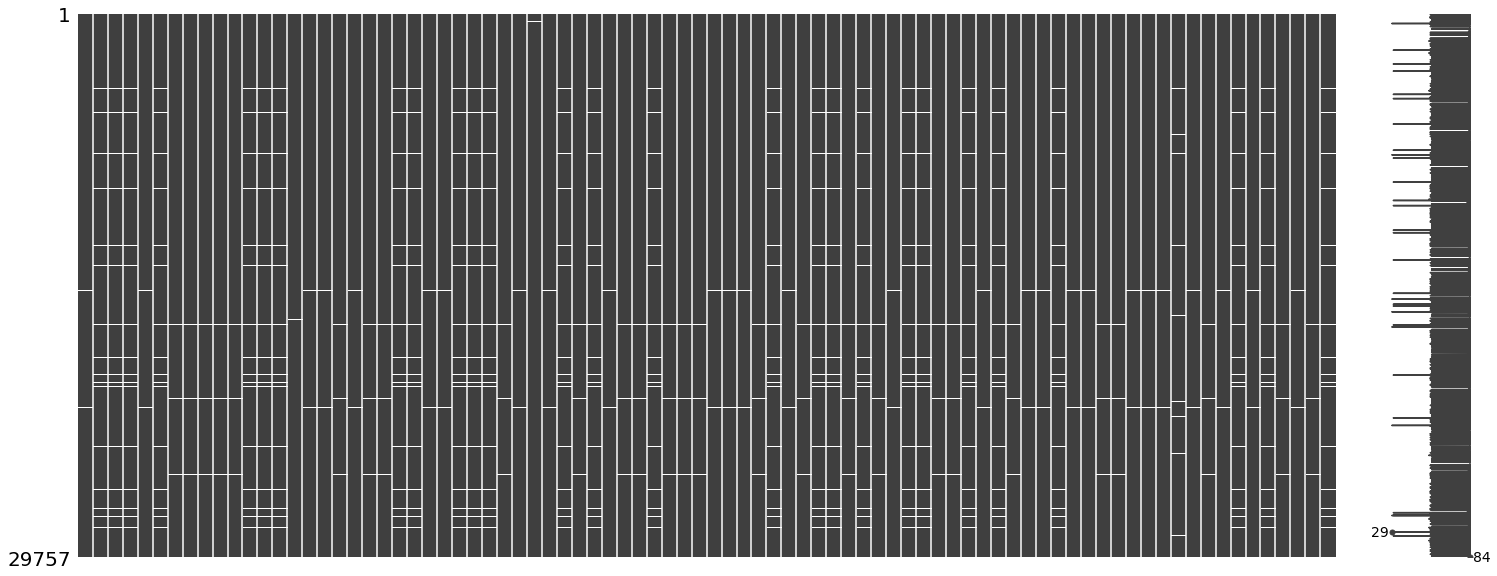

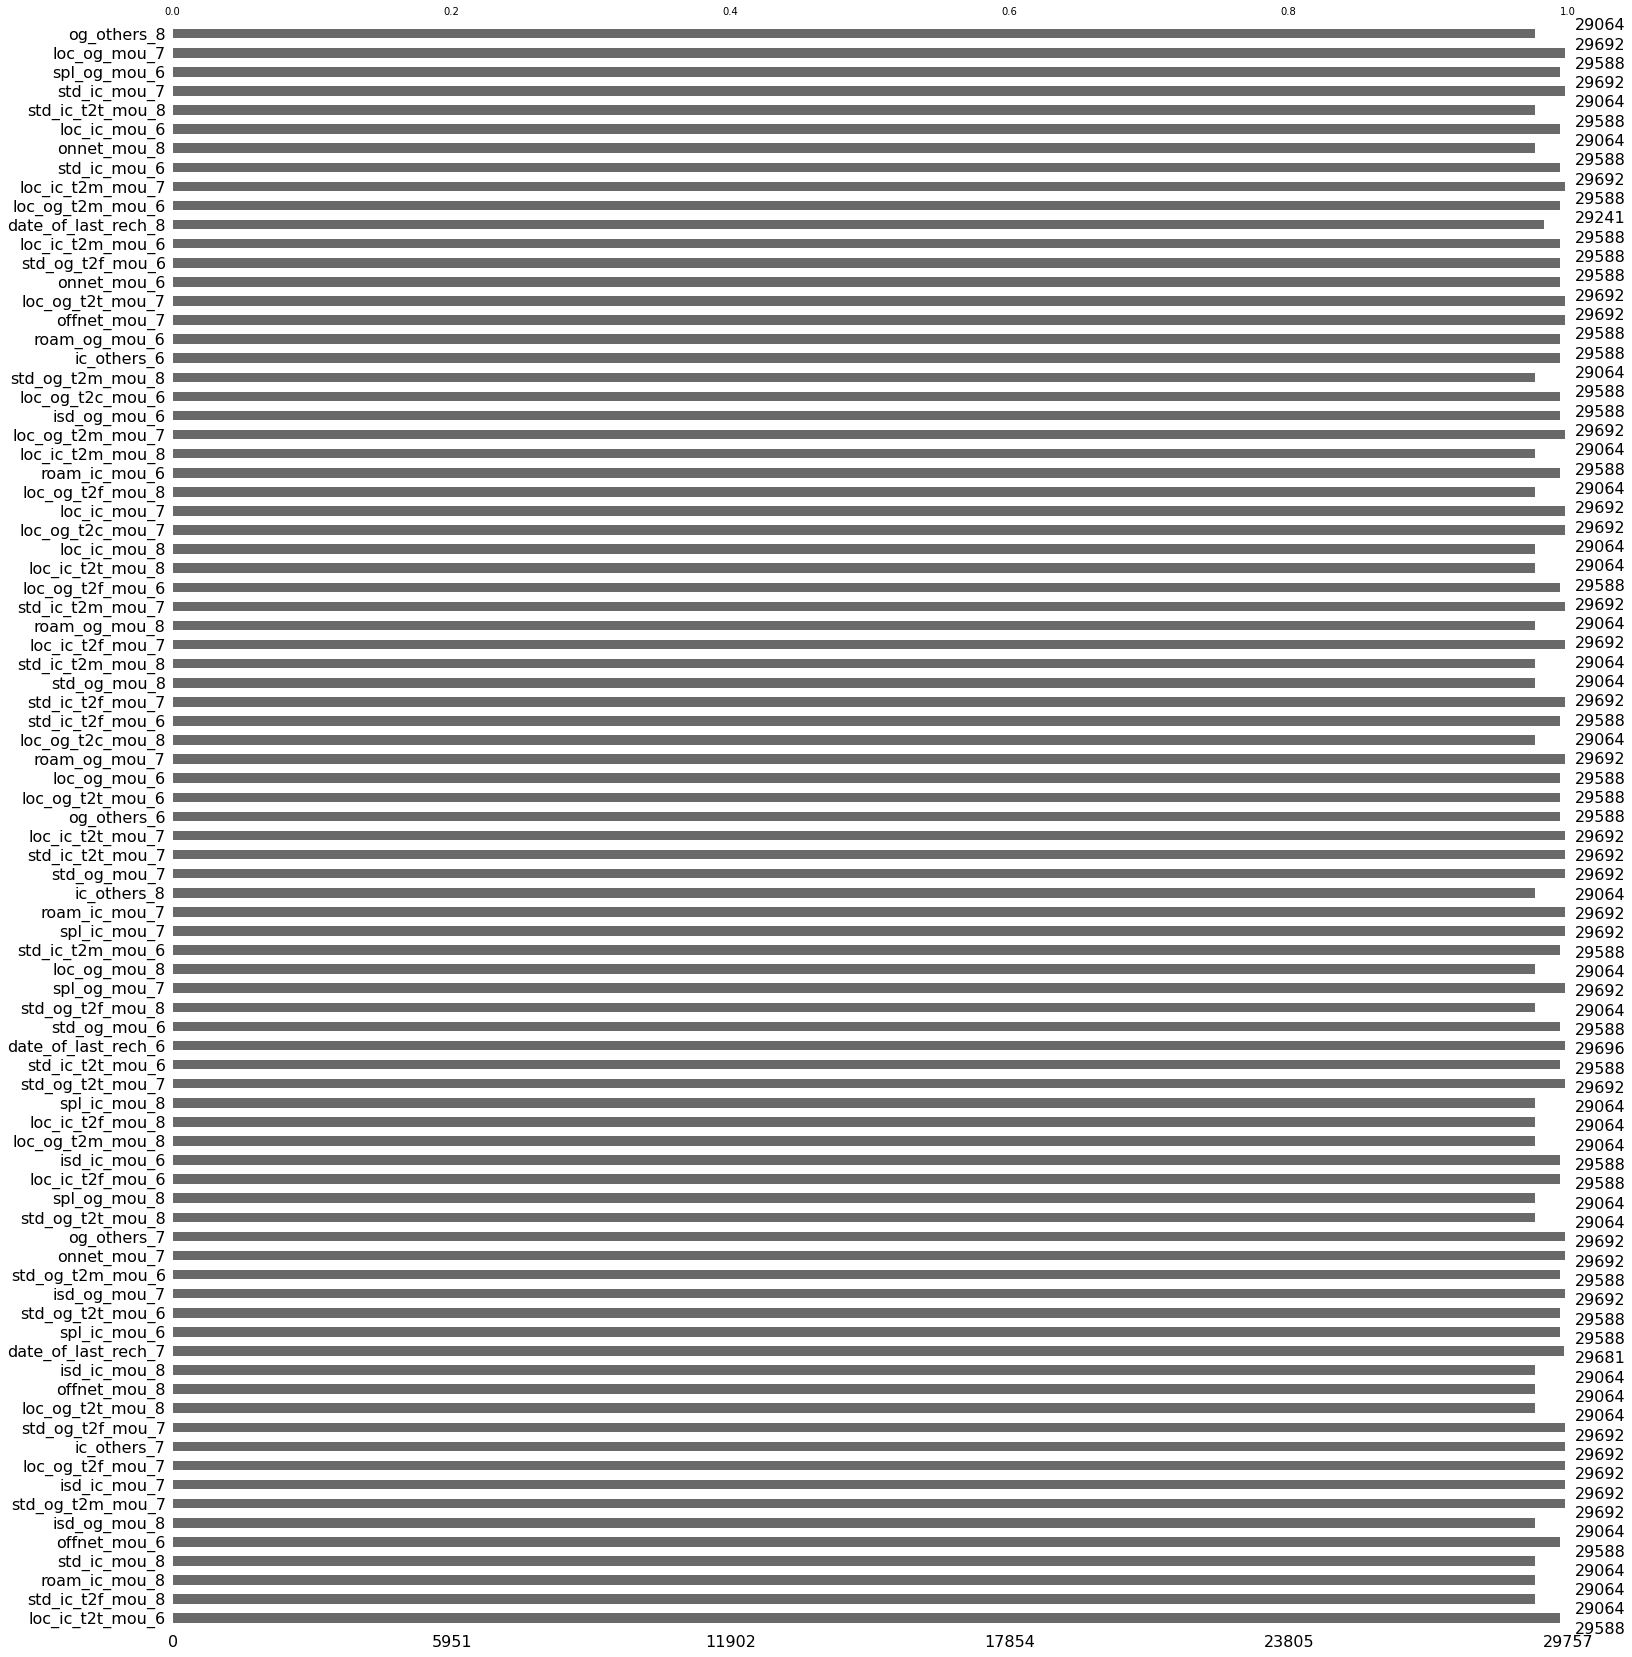

Columns with missing data: 84 64.62%
std_ic_t2f_mou_8, roam_ic_mou_8, std_ic_mou_8, isd_og_mou_8, loc_og_t2t_mou_8, offnet_mou_8, isd_ic_mou_8, std_og_t2t_mou_8, spl_og_mou_8, loc_og_t2m_mou_8, loc_ic_t2f_mou_8, spl_ic_mou_8, std_og_t2f_mou_8, loc_og_mou_8, ic_others_8, loc_og_t2c_mou_8, std_og_mou_8, std_ic_t2m_mou_8, roam_og_mou_8, loc_ic_t2t_mou_8, loc_ic_mou_8, loc_og_t2f_mou_8, loc_ic_t2m_mou_8, std_og_t2m_mou_8, onnet_mou_8, std_ic_t2t_mou_8, og_others_8, date_of_last_rech_8, loc_ic_t2t_mou_6, offnet_mou_6, spl_ic_mou_6, std_og_t2t_mou_6, std_og_t2m_mou_6, loc_ic_t2f_mou_6, isd_ic_mou_6, std_ic_t2t_mou_6, std_og_mou_6, std_ic_t2m_mou_6, og_others_6, loc_og_t2t_mou_6, loc_og_mou_6, std_ic_t2f_mou_6, loc_og_t2f_mou_6, roam_ic_mou_6, isd_og_mou_6, loc_og_t2c_mou_6, ic_others_6, roam_og_mou_6, onnet_mou_6, std_og_t2f_mou_6, loc_ic_t2m_mou_6, loc_og_t2m_mou_6, std_ic_mou_6, loc_ic_mou_6, spl_og_mou_6, date_of_last_rech_7, std_og_t2m_mou_7, isd_ic_mou_7, loc_og_t2f_mou_7, ic_others_7, 

In [54]:
displayColumnsWithMissingData(df)
COLS_MISS = listColumsWithMissingData(df, 0)
[print(col[0], end=', ') for col in COLS_MISS];print()

In [55]:
sum(df.isnull().values.any(axis=1))

1270

## Impute Missing Values

In [56]:
COLS_CAT = getCategoricalColumns(df)
#plotCategoricalVariables(df, COLS_CAT, "")

Columns with categorical values 3 --> ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']


The columns date_of_last_rech_<mon> have the complete date. Month and year are redundant as they are same for all the rows. Let's just store the day alone.

In [57]:
for mon in [6,7,8]:
    col = f'date_of_last_rech_{mon}';print(col)
    print(df[col].unique())
    df[col] = df[col].apply(pd.to_datetime)
    df[col] = df[col].dt.day
    print(df[col].unique())
#plotCategoricalVariables(df, COLS_CAT, "")

date_of_last_rech_6
['6/27/2014' '6/25/2014' '6/20/2014' '6/30/2014' '6/23/2014' '6/24/2014'
 '6/29/2014' '6/28/2014' '6/26/2014' '6/21/2014' '6/17/2014' '6/22/2014'
 '6/13/2014' '6/16/2014' '6/12/2014' '6/15/2014' '6/18/2014' '6/8/2014'
 '6/19/2014' '6/2/2014' '6/7/2014' '6/4/2014' '6/14/2014' '6/11/2014' nan
 '6/9/2014' '6/10/2014' '6/3/2014' '6/5/2014' '6/1/2014' '6/6/2014']
[27. 25. 20. 30. 23. 24. 29. 28. 26. 21. 17. 22. 13. 16. 12. 15. 18.  8.
 19.  2.  7.  4. 14. 11. nan  9. 10.  3.  5.  1.  6.]
date_of_last_rech_7
['7/25/2014' '7/31/2014' '7/22/2014' '7/30/2014' '7/17/2014' '7/28/2014'
 '7/23/2014' '7/26/2014' '7/29/2014' '7/27/2014' '7/19/2014' '7/20/2014'
 '7/7/2014' '7/24/2014' '7/15/2014' '7/9/2014' '7/13/2014' '7/18/2014'
 '7/16/2014' '7/21/2014' nan '7/5/2014' '7/12/2014' '7/11/2014'
 '7/10/2014' '7/1/2014' '7/14/2014' '7/6/2014' '7/8/2014' '7/2/2014'
 '7/4/2014' '7/3/2014']
[25. 31. 22. 30. 17. 28. 23. 26. 29. 27. 19. 20.  7. 24. 15.  9. 13. 18.
 16. 21. nan  5. 12. 11. 

In [58]:
COLS_NUM = getNumericalColumns(df)
#plotNumericalVariables(df, COLS_NUM, "")
#plotBoxPlots(df, COLS_NUM)

Columns with numerical values 130 --> ['aon', 'arpu_6', 'arpu_7', 'arpu_8', 'aug_vbc_3g', 'avg_rech_amt_67', 'churn', 'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'ic_others_6', 'ic_others_7', 'ic_others_8', 'isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'jul_vbc_3g', 'jun_vbc_3g', 'last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'monthly

1. Categorical variables: Impute with mode
    - Towards the end of the month the recharge is higher
2. Numerical Variables 
    - w/o outliers: 'aon', 'isd_lc_mou_6', 'lou_lc_mou_6'. The missing values in these columns can be imputed with mean. 
    - Rest (with outliers) should be imputed with median values

In [59]:
print("Before", df.isnull().sum().sum())
print("DF SHAPE", df.shape, end='')

for column in COLS_MISS:
    col = column[0]
    if df[col].dtype == np.float64:
        if col in ['aon', 'isd_lc_mou_6', 'lou_lc_mou_6']:
            print(col)
            df[col].fillna(df[col].mean(), inplace=True)
        else:
            df[col].fillna(df[col].median(), inplace=True)
    elif df[col].dtype == 'object':
        #print(col,  df[col].dtype, df[col].mode().values[0])
        df[col].fillna(df[col].mode().values[0], inplace=True)

print("-->", df.shape)
print("After", df.isnull().sum().sum())

Before 25682
DF SHAPE (29757, 130)--> (29757, 130)
After 0


## Handle Outliers

3 1


<Figure size 720x576 with 0 Axes>

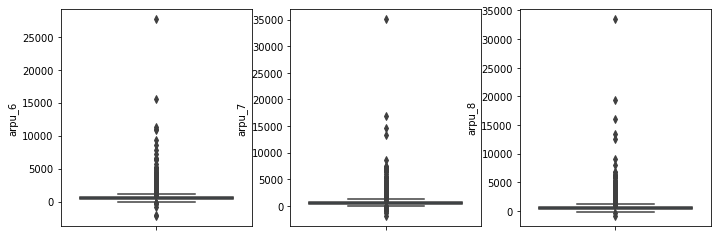

In [60]:
#Checking outliers in Average revenue per user for months 6,7 & 8
plt.figure(figsize=(10,8)); plotBoxPlots(df, ['arpu_6','arpu_7','arpu_8'])

We can see outliers in arpu exceeding 30000 , as some high valued customers might contribute very high revenues we will choose consider these genuine values and wont remove these.
But we can also see some negative values here.If a customer is not generating any revenue then the value has to be 0 ,it cannot be negative.So removing these values

In [61]:
# Removing negavtive outliers from arpu column
print("DF SHAPE: ", df.shape, end=' ')
df = df[(df['arpu_6'] >= 0) & (df['arpu_7'] >= 0) & (df['arpu_8'] >= 0)]
print(" --> ", df.shape)

DF SHAPE:  (29757, 130)  -->  (29619, 130)


3 1


<Figure size 720x576 with 0 Axes>

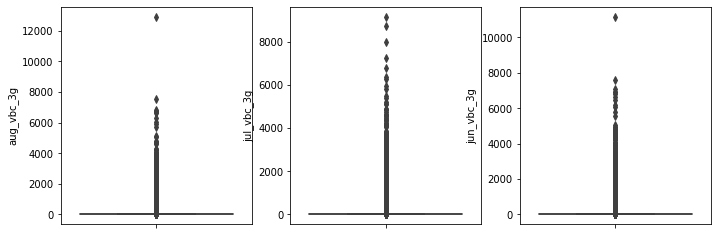

In [62]:
#Checking outliers in volume based cost per user for months 6,7 & 8
plt.figure(figsize=(10,8)); plotBoxPlots(df, ['aug_vbc_3g','jul_vbc_3g','jun_vbc_3g'])

We can consider values above 10000 as outliers .

In [63]:
#Removing Outliers
print("DF SHAPE: ", df.shape, end=' ')
df = df[(df['aug_vbc_3g']<=10000) & (df['jul_vbc_3g']<=10000) & (df['jun_vbc_3g']<=10000) ]
print(" --> ", df.shape)

DF SHAPE:  (29619, 130)  -->  (29617, 130)


3 1


<Figure size 720x576 with 0 Axes>

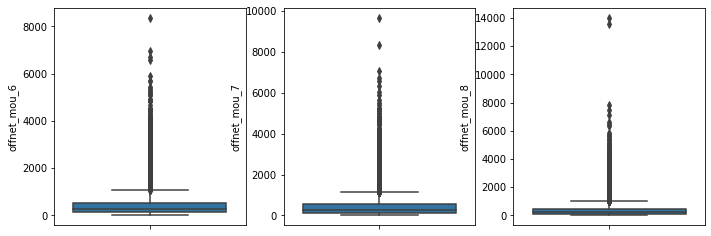

In [64]:
#Checking outliers in All kind of calls outside the operator T network  for months 6,7 & 8
plt.figure(figsize=(10,8))
plotBoxPlots(df, ['offnet_mou_6','offnet_mou_7','offnet_mou_8'])

We will remove these outliers above 7000

In [65]:
print("DF SHAPE: ", df.shape, end=' ')
df = df[(df['offnet_mou_6']<=7000) & (df['offnet_mou_7']<=7000) & (df['offnet_mou_8']<=7000) ]
print(" --> ", df.shape)

DF SHAPE:  (29617, 130)  -->  (29610, 130)


3 1


<Figure size 720x576 with 0 Axes>

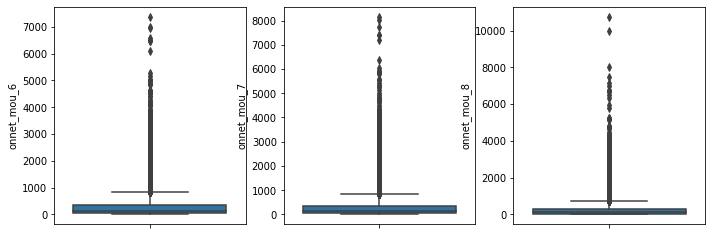

In [66]:
#Checking outliers in onnet for months 6,7 & 8
plt.figure(figsize=(10,8)); plotBoxPlots(df, ['onnet_mou_6','onnet_mou_7','onnet_mou_8'])

We will remove the outliers above 6000 and 8000 respectively

In [67]:
print("DF SHAPE: ", df.shape, end=' ')
df = df[(df['onnet_mou_6']<=6000) & (df['onnet_mou_7']<=8000) & (df['onnet_mou_8']<=8000) ]
print(" --> ", df.shape)

DF SHAPE:  (29610, 130)  -->  (29600, 130)


6 2


<Figure size 720x576 with 0 Axes>

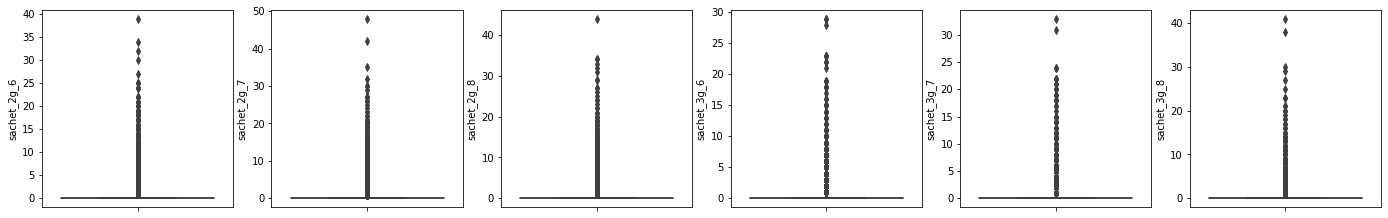

In [68]:
#Checking for outliers in sachet columns
plt.figure(figsize=(10,8));plotBoxPlots(df, ['sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8','sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8'])

We can see few ouliers above 45

In [69]:
#Removing these outliers
print("DF SHAPE: ", df.shape, end=' ')
df = df[(df['sachet_2g_6']<=45) &(df['sachet_2g_7']<=45) &(df['sachet_2g_8']<=45) &(df['sachet_3g_6']<=25) &(df['sachet_3g_7']<=25) &(df['sachet_3g_8']<=25) ]
print(" --> ", df.shape)

DF SHAPE:  (29600, 130)  -->  (29590, 130)


12 3


<Figure size 1440x720 with 0 Axes>

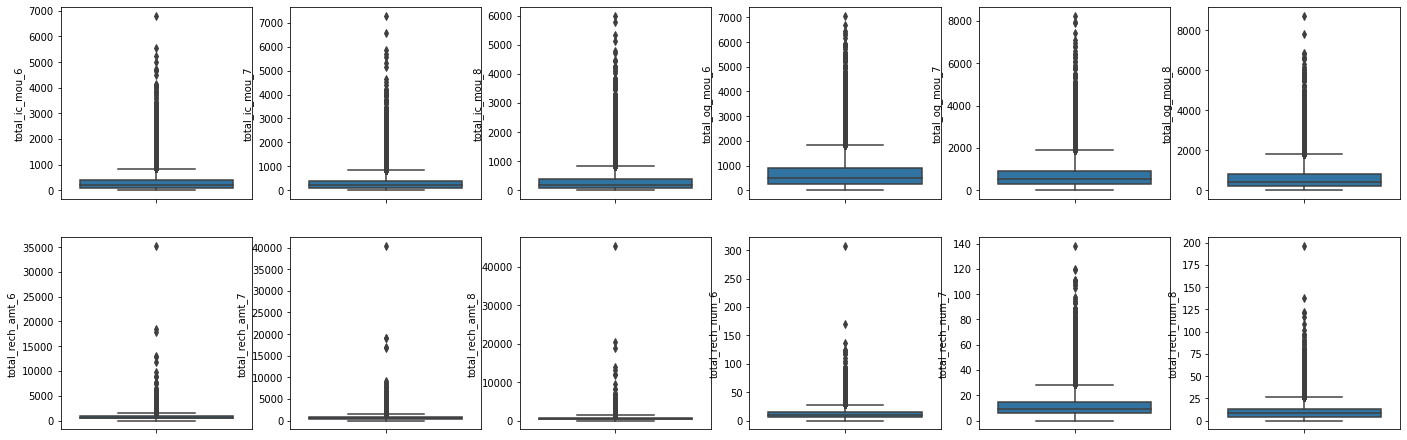

In [70]:
plt.figure(figsize=(20,10))
plotBoxPlots(df, ['total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8',
 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8'])

There are quite a few outliers ,so we will be removing those.

In [71]:
print("DF SHAPE: ", df.shape, end=' ')
#Removing outliers
df = df[(df['total_ic_mou_6']<=6000) & (df['total_ic_mou_7']<=6000) & (df['total_ic_mou_8']<=6000) &
        (df['total_og_mou_6']<=8000) & (df['total_og_mou_7']<=8000) & (df['total_og_mou_8']<=8000) &
        (df['total_rech_amt_6']<=30000) & (df['total_rech_amt_7']<=30000) & (df['total_rech_amt_8']<=30000) &
        (df['total_rech_num_6']<=300) & (df['total_rech_num_7']<=300) & (df['total_rech_num_8']<=300) ]
print(" --> ", df.shape)

DF SHAPE:  (29590, 130)  -->  (29584, 130)


6 2


<Figure size 720x576 with 0 Axes>

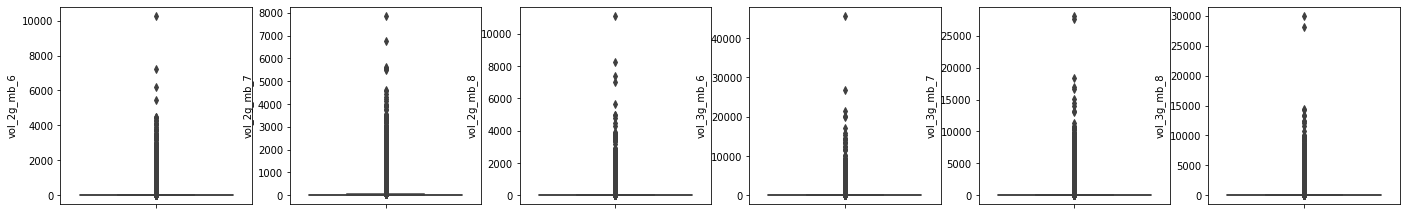

In [72]:
#Checking for outliers in Mobile internet usage volume (in MB)
plt.figure(figsize=(10,8));plotBoxPlots(df,['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8'])

It can be observed here that outlier range drastically increases for 3g data. The highest outlier in 2g data is around 11000 whereas in 3g it is above 30000.

In [73]:
print("DF SHAPE: ", df.shape, end=' ')
#Removing outliers
df = df[(df['vol_2g_mb_6']<=8000) &(df['vol_2g_mb_7']<=8000) &(df['vol_2g_mb_8']<=8000) &
        (df['vol_3g_mb_6']<=40000) &(df['vol_3g_mb_7']<=20000) &(df['vol_3g_mb_8']<=30000) ]
print(" --> ", df.shape)

DF SHAPE:  (29584, 130)  -->  (29580, 130)


3 1


<Figure size 720x576 with 0 Axes>

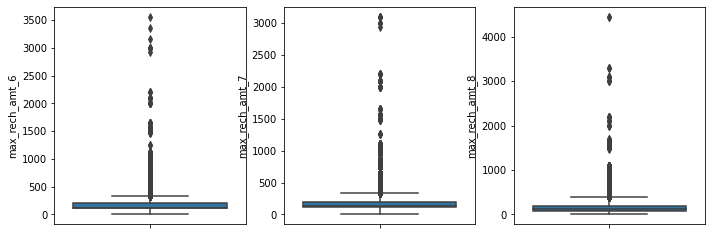

In [74]:
#Checking for outliers in column Max recharge amount
plt.figure(figsize=(10,8))
plotBoxPlots(df, [ 'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8'])

Maximum recharge amount can vary for customers and its better not to remove these outliers as this might influence churn rate.

## Create Dummy variables


In [75]:
#Since for our analysis we will drop these
drop_cols = ['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8']
df.drop(drop_cols,axis=1,inplace=True)

In [76]:
#Checking for any object type columns in our data
df.select_dtypes(include=['object']).columns.tolist()

[]

There are no categorical variables in our data so we do not need to create dummy variables.

## Derive new features

1. avg_rech_amt_67: average average recharge amount in the good phase (months 6 & 7)
2. 'vol_mb_67', 'vol_mb_78': Difference in the internet usage between the months 6,7 & 8
3. 'total_mou_67', 'total_mou_78': Difference in the calls between the months 6,7 & 8
4. 'arpu67', 'arpu_78': Difference in the revenue between the months 6,7 & 8

In [77]:
df['vol_mb_6'] = df['vol_2g_mb_6'] + df['vol_3g_mb_6']
df['vol_mb_7'] = df['vol_2g_mb_7'] + df['vol_3g_mb_7']
df['vol_mb_8'] = df['vol_2g_mb_8'] + df['vol_3g_mb_8']

df['vol_mb'] = df['vol_mb_6'] + df['vol_mb_7'] + df['vol_mb_8']
df['vol_mb_67'] = df['vol_mb_7'] - df['vol_mb_6']
df['vol_mb_78'] = df['vol_mb_8'] - df['vol_mb_7']

In [78]:
df['total_mou_6'] = df['total_ic_mou_6'] + df['total_og_mou_6']
df['total_mou_7'] = df['total_ic_mou_7'] + df['total_og_mou_7']
df['total_mou_8'] = df['total_ic_mou_8'] + df['total_og_mou_8']

df['total_mou'] = df['total_mou_6'] + df['total_mou_7'] + df['total_mou_8']
df['total_mou_67'] = df['total_mou_7'] - df['total_mou_6']
df['total_mou_78'] = df['total_mou_8'] - df['total_mou_7']

In [79]:
df['arpu']    = df['arpu_6'] + df['arpu_7'] + df['arpu_8']
df['arpu_67'] = df['arpu_7'] - df['arpu_6']
df['arpu_78'] = df['arpu_8'] - df['arpu_7']

In [80]:
df[['arpu', 'arpu_67', 'arpu_78']].head()

,arpu,arpu_67,arpu_78
0,5590.510,280.670,1821.630
1,1008.306,113.502,-354.861
2,1291.777,-287.175,387.589
3,918.738,-131.106,-111.975
4,734.487,-671.028,6.519


,churn,67,78
vol_mb,0,24.5876,-6.92312
total_mou,0,54.9194,-61.8045
arpu,0,14.1384,-31.6137
vol_mb,1,-27.457,-129.163
total_mou,1,-187.16,-615.01
arpu,1,-77.0366,-318.717


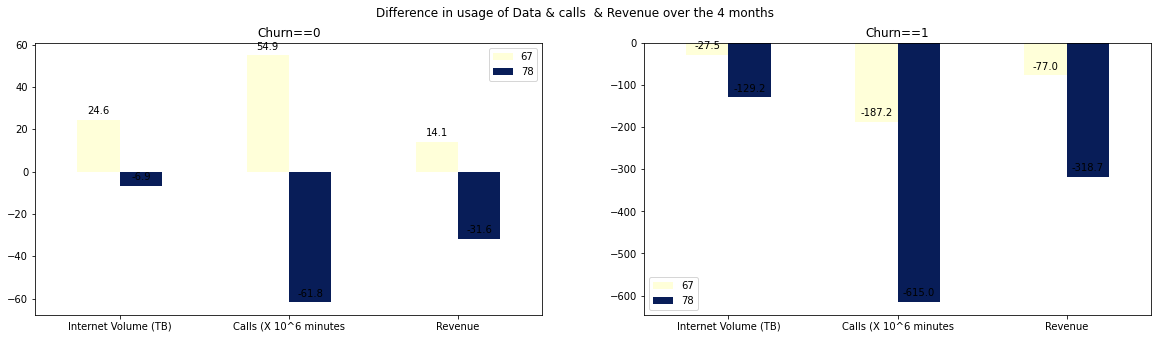

In [82]:
COLS_ = ['vol_mb', 'total_mou', 'arpu']

df_0 = pd.DataFrame(columns=COLS_) 
df_1 = pd.DataFrame(columns=COLS_)
for mon in [67, 78]:
    for col in COLS_:
        #print(mon, f'{col}_{mon}', int(df[f'{col}_{mon}'].mean()), int(df[f'{col}_{mon}'].median()))
        df_0.loc[f'{mon}', col] = df[df['churn']==0][f'{col}_{mon}'].mean()
        df_1.loc[f'{mon}', col] = df[df['churn']==1][f'{col}_{mon}'].mean()

COLS_USAGE_REVENUE = ['Internet Volume (TB)', 'Calls (X 10^6 minutes', 'Revenue']
df_0 = df_0.transpose()
df_1 = df_1.transpose()

fig = plt.figure(figsize=(20,5)); fig.suptitle("Difference in usage of Data & calls  & Revenue over the 4 months")
ax = plt.subplot(1,2,1); ax = df_0.plot.bar(cmap='YlGnBu', ax=ax); annotate(ax, title="Churn==0"); ax.set_xticklabels(COLS_USAGE_REVENUE, rotation=0)
ax = plt.subplot(1,2,2); ax = df_1.plot.bar(cmap='YlGnBu', ax=ax); annotate(ax, title="Churn==1"); ax.set_xticklabels(COLS_USAGE_REVENUE, rotation=0)
print()

df_0['churn'] = 0
df_1['churn'] = 1
pd.concat([df_0,df_1])[['churn','67','78']]

In [83]:
COLS = df.columns.tolist()

In [84]:
listColumns(df)

142 ['loc_ic_t2t_mou_6', 'std_ic_t2f_mou_8', 'roam_ic_mou_8', 'sachet_3g_7', 'std_ic_mou_8', 'offnet_mou_6', 'isd_og_mou_8', 'std_og_t2m_mou_7', 'isd_ic_mou_7', 'loc_og_t2f_mou_7', 'ic_others_7', 'vol_2g_mb_8', 'sachet_2g_7', 'std_og_t2f_mou_7', 'loc_og_t2t_mou_8', 'offnet_mou_8', 'sachet_3g_8', 'isd_ic_mou_8', 'vol_3g_mb_7', 'total_rech_amt_6', 'spl_ic_mou_6', 'total_og_mou_8', 'std_og_t2t_mou_6', 'max_rech_amt_8', 'monthly_3g_8', 'isd_og_mou_7', 'std_og_t2m_mou_6', 'onnet_mou_7', 'og_others_7', 'total_rech_num_6', 'total_rech_amt_8', 'std_og_t2t_mou_8', 'spl_og_mou_8', 'loc_ic_t2f_mou_6', 'isd_ic_mou_6', 'loc_og_t2m_mou_8', 'loc_ic_t2f_mou_8', 'vol_3g_mb_6', 'sachet_2g_8', 'spl_ic_mou_8', 'avg_rech_amt_67', 'std_og_t2t_mou_7', 'std_ic_t2t_mou_6', 'arpu_8', 'sachet_3g_6', 'std_og_mou_6', 'std_og_t2f_mou_8', 'max_rech_amt_6', 'aug_vbc_3g', 'total_ic_mou_7', 'last_day_rch_amt_8', 'spl_og_mou_7', 'loc_og_mou_8', 'std_ic_t2m_mou_6', 'spl_ic_mou_7', 'roam_ic_mou_7', 'ic_others_8', 'vol_2g_

In [85]:
df.shape

(29580, 142)

## Check correlations and drop 

In [86]:
def getTopNCorrelations(df, n):
    c = df.corr().abs()
    s = c.unstack()
    cldf = s.sort_values(kind="quicksort", ascending=False).to_frame().reset_index()
    cldf = cldf[cldf['level_0']!=cldf['level_1']]
    cldf = cldf.rename(columns={'level_0':'Variable1', 'level_1':'Variable2', 0:'CORR'})
    cldf['vars'] = cldf['Variable1'] + cldf['Variable2']
    cldf['vars'] = cldf['vars'].apply(lambda x: "".join(sorted(x)))
    cldf['CORR'] = round(cldf['CORR'], 2)
    cldf = cldf.drop_duplicates('vars')[['Variable1', 'Variable2', 'CORR']][0:n]
    return cldf

Variable2,arpu,arpu_7,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_mou,total_mou_7,total_mou_8,total_og_mou_6,total_rech_amt_6,total_rech_amt_8,vol_3g_mb_6,vol_3g_mb_7,vol_mb_7,vol_mb_8
Variable1,,,,,,,,,,,,,,,,,,
arpu_6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.94,0.00,0.00,0.00,0.00,0.00
arpu_7,0.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
arpu_8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.95,0.00,0.00,0.00,0.00
avg_rech_amt_67,0.94,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
isd_og_mou_6,0.00,0.00,0.00,0.92,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
isd_og_mou_7,0.00,0.00,0.00,0.00,0.92,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
isd_og_mou_8,0.00,0.00,0.92,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
loc_ic_mou_6,0.00,0.00,0.00,0.00,0.00,0.89,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
loc_ic_mou_7,0.00,0.00,0.00,0.00,0.00,0.00,0.88,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00


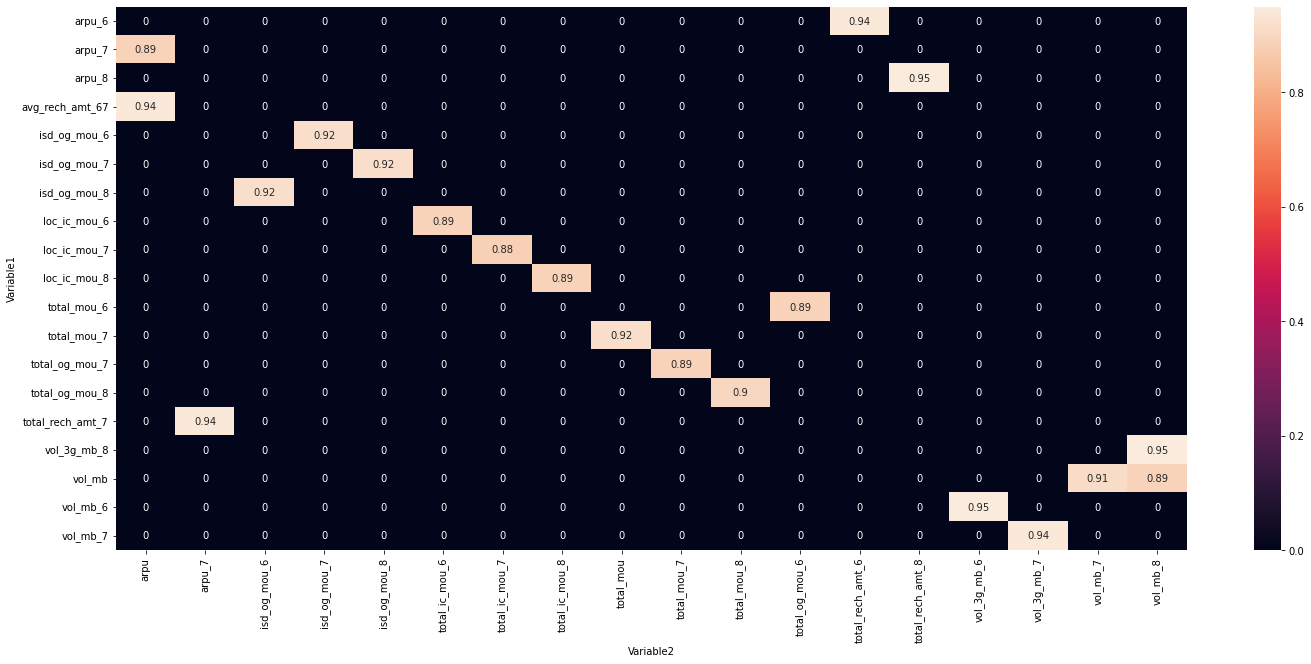

In [87]:
c1 = getTopNCorrelations(df, 20)
c1 = c1.head(20)
c1 = pd.pivot_table(data=c1, index='Variable1', columns='Variable2', values='CORR').fillna(0)
plt.figure(figsize = (24,10)); sns.heatmap(c1,annot = True)
c1

TODO: Re-check if anything is dropped

There are quite a few highly correlaed variables
We wont be dropping any correlation varibales as we will use PCA and RFE in later stages for dimensionality reduction

In [88]:
#Commented the code for dropping highly correlated variables as we have decided not to drop any variables as of now.
'''df_ = df.copy()
#cols_to_drop = ['vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8', 'arpu_6', 'arpu_7', 'arpu_8', ]
#df_.drop(columns=cols_to_drop, inplace=True)
c1 = getTopNCorrelations(df_, 20)
c1 = pd.pivot_table(data=c1, index='Variable1', columns='Variable2', values='CORR').fillna(0)
plt.figure(figsize = (24,10)); sns.heatmap(c1,annot = True)
c1'''

"df_ = df.copy()\n#cols_to_drop = ['vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8', 'arpu_6', 'arpu_7', 'arpu_8', ]\n#df_.drop(columns=cols_to_drop, inplace=True)\nc1 = getTopNCorrelations(df_, 20)\nc1 = pd.pivot_table(data=c1, index='Variable1', columns='Variable2', values='CORR').fillna(0)\nplt.figure(figsize = (24,10)); sns.heatmap(c1,annot = True)\nc1"

# Prepare data

In [89]:
df.shape

(29580, 142)

In [90]:
COLS_DATE = ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']
COLS_NUM = getNumericalColumns(df)
COLS_CAT = [getCategoricalColumns(df)]
COLS_NUM = list(set(COLS_NUM) - set(COLS_DATE))
print(len(COLS_NUM), COLS_NUM)

Columns with numerical values 142 --> ['aon', 'arpu', 'arpu_6', 'arpu_67', 'arpu_7', 'arpu_78', 'arpu_8', 'aug_vbc_3g', 'avg_rech_amt_67', 'churn', 'ic_others_6', 'ic_others_7', 'ic_others_8', 'isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'jul_vbc_3g', 'jun_vbc_3g', 'last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8',

In [91]:
listColumns(df)

142 ['loc_ic_t2t_mou_6', 'std_ic_t2f_mou_8', 'roam_ic_mou_8', 'sachet_3g_7', 'std_ic_mou_8', 'offnet_mou_6', 'isd_og_mou_8', 'std_og_t2m_mou_7', 'isd_ic_mou_7', 'loc_og_t2f_mou_7', 'ic_others_7', 'vol_2g_mb_8', 'sachet_2g_7', 'std_og_t2f_mou_7', 'loc_og_t2t_mou_8', 'offnet_mou_8', 'sachet_3g_8', 'isd_ic_mou_8', 'vol_3g_mb_7', 'total_rech_amt_6', 'spl_ic_mou_6', 'total_og_mou_8', 'std_og_t2t_mou_6', 'max_rech_amt_8', 'monthly_3g_8', 'isd_og_mou_7', 'std_og_t2m_mou_6', 'onnet_mou_7', 'og_others_7', 'total_rech_num_6', 'total_rech_amt_8', 'std_og_t2t_mou_8', 'spl_og_mou_8', 'loc_ic_t2f_mou_6', 'isd_ic_mou_6', 'loc_og_t2m_mou_8', 'loc_ic_t2f_mou_8', 'vol_3g_mb_6', 'sachet_2g_8', 'spl_ic_mou_8', 'avg_rech_amt_67', 'std_og_t2t_mou_7', 'std_ic_t2t_mou_6', 'arpu_8', 'sachet_3g_6', 'std_og_mou_6', 'std_og_t2f_mou_8', 'max_rech_amt_6', 'aug_vbc_3g', 'total_ic_mou_7', 'last_day_rch_amt_8', 'spl_og_mou_7', 'loc_og_mou_8', 'std_ic_t2m_mou_6', 'spl_ic_mou_7', 'roam_ic_mou_7', 'ic_others_8', 'vol_2g_

In [92]:
# Split df into train and test.
# Note: Use ```stratify``` to preserve the poportion of the target variable churn=1 & churn=0 in train and test datasets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df[COL_TARGET])
print("TRAIN:", df_train.shape,"\n", df_train[COL_TARGET].value_counts(normalize=True)*100, "\n", sep='')
print("TEST:" , df_test.shape, "\n", df_test[COL_TARGET].value_counts(normalize=True)*100, "\n",  sep='')

# Create X_train & y_train
X_train = df_train[list(set(COLS)-set([COL_TARGET]))]
y_train = df_train[COL_TARGET]
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(type(X_train), type(y_train))

# Create X_test & y_test
X_test = df_test[list(set(COLS)-set([COL_TARGET]))]
y_test = df_test[COL_TARGET]
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(type(X_test), type(y_test))

TRAIN:(23664, 142)
0    92.004733
1     7.995267
Name: churn, dtype: float64

TEST:(5916, 142)
0    92.004733
1     7.995267
Name: churn, dtype: float64

X_train: (23664, 141), y_train: (23664,)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>
X_test: (5916, 141), y_test: (5916,)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


In [93]:
cols = X_train.columns.tolist()

# Using MinMaxScaler as the numerical values (usage, revenue etc) should be > 0 
scaler = MinMaxScaler()
X_train[cols] = scaler.fit_transform(X_train)
print(type(X_train), type(y_train))
X_train.head()

X_test[cols] = scaler.transform(X_test[cols])
X_test.head()

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


,loc_ic_t2t_mou_6,sachet_3g_7,std_ic_t2f_mou_8,roam_ic_mou_8,std_ic_mou_8,total_mou_6,offnet_mou_6,total_mou_78,isd_og_mou_8,std_og_t2m_mou_7,isd_ic_mou_7,ic_others_7,loc_og_t2f_mou_7,vol_2g_mb_8,sachet_2g_7,std_og_t2f_mou_7,loc_og_t2t_mou_8,offnet_mou_8,sachet_3g_8,isd_ic_mou_8,vol_3g_mb_7,arpu_67,total_rech_amt_6,spl_ic_mou_6,total_og_mou_8,std_og_t2t_mou_6,arpu_78,max_rech_amt_8,monthly_3g_8,isd_og_mou_7,std_og_t2m_mou_6,onnet_mou_7,og_others_7,total_rech_num_6,total_rech_amt_8,std_og_t2t_mou_8,spl_og_mou_8,loc_ic_t2f_mou_6,isd_ic_mou_6,loc_og_t2m_mou_8,...,total_rech_amt_7,total_og_mou_6,isd_og_mou_6,loc_og_t2c_mou_6,std_og_t2m_mou_8,ic_others_6,vol_2g_mb_6,sep_vbc_3g,roam_og_mou_6,offnet_mou_7,vol_3g_mb_8,loc_og_t2t_mou_7,arpu,jun_vbc_3g,onnet_mou_6,monthly_2g_7,std_og_t2f_mou_6,vol_mb_8,loc_ic_t2m_mou_6,sachet_2g_6,loc_og_t2m_mou_6,loc_ic_t2m_mou_7,jul_vbc_3g,std_ic_mou_6,last_day_rch_amt_6,arpu_6,total_mou_7,monthly_2g_8,onnet_mou_8,vol_mb,loc_ic_mou_6,total_ic_mou_6,std_ic_t2t_mou_8,std_ic_mou_7,monthly_3g_6,last_day_rch_amt_7,spl_og_mou_6,loc_og_mou_7,og_others_8,total_ic_mou_8
11779,0.000718,0.0,0.000000,0.000000,0.004957,0.140315,0.041625,0.479322,0.000000,0.104101,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000149,0.090255,0.0,0.000000,0.000000,0.355068,0.022486,0.000000,0.129371,0.156029,0.475334,0.037986,0.0,0.00000,0.041524,0.052252,0.0,0.029412,0.023377,0.046551,0.000000,0.000000,0.000000,0.004268,...,0.033118,0.148142,0.000000,0.0,0.090600,0.000000,0.000000,0.000000,0.000000,0.109973,0.0,0.000448,0.024609,0.000000,0.149159,0.0,0.000000,0.000000,0.001675,0.0,0.004608,0.003108,0.000000,0.016126,0.010746,0.028571,0.142407,0.0,0.045150,0.000000,0.002317,0.017890,0.000926,0.013056,0.000000,0.035484,0.000000,0.007354,0.0,0.007897
20181,0.004210,0.0,0.000000,0.006705,0.000000,0.178566,0.003282,0.356487,0.000000,0.005412,0.000000,0.000334,0.000000,0.000000,0.0,0.000000,0.000000,0.008663,0.0,0.000000,0.000000,0.356277,0.036162,0.000000,0.000000,0.267852,0.465125,0.029220,0.0,0.00000,0.000000,0.218032,0.0,0.058824,0.014016,0.000000,0.000000,0.000000,0.000744,0.000000,...,0.049625,0.196368,0.000000,0.0,0.000000,0.000900,0.000000,0.000000,0.013851,0.015377,0.0,0.007700,0.030536,0.000000,0.274022,0.0,0.000000,0.000000,0.005950,0.0,0.003676,0.007635,0.000000,0.003744,0.032836,0.038478,0.198871,0.0,0.036465,0.000000,0.009734,0.012767,0.000000,0.004265,0.071429,0.038710,0.000000,0.015503,0.0,0.000000
2253,0.076811,0.0,0.006280,0.000494,0.004589,0.139681,0.050174,0.551686,0.003452,0.000000,0.000000,0.031057,0.078283,0.000000,0.0,0.009346,0.011665,0.083183,0.0,0.000007,0.000000,0.304601,0.063081,0.009615,0.091319,0.000000,0.504611,0.123623,0.0,0.00000,0.000000,0.007035,0.0,0.035294,0.053908,0.000331,0.000000,0.015957,0.003185,0.115172,...,0.000000,0.062444,0.003157,0.0,0.002709,0.069517,0.000000,0.000351,0.005218,0.051534,0.0,0.005404,0.055903,0.011660,0.021944,0.0,0.000000,0.000000,0.051139,0.0,0.062425,0.068097,0.000635,0.000000,0.164179,0.089167,0.109532,0.0,0.012610,0.000000,0.125244,0.126239,0.000000,0.001446,0.000000,0.000000,0.000000,0.050910,0.0,0.143821
21616,0.014439,0.0,0.027271,0.000000,0.006478,0.083239,0.027763,0.498607,0.005986,0.002239,0.006087,0.000000,0.036993,0.000000,0.0,0.002222,0.018841,0.039793,0.0,0.000000,0.017344,0.358171,0.036703,0.000000,0.055994,0.000000,0.497092,0.056192,0.0,0.00267,0.001075,0.016956,0.0,0.041176,0.061259,0.000000,0.000000,0.004778,0.000000,0.036094,...,0.033587,0.045548,0.000000,0.0,0.003635,0.000000,0.007518,0.000000,0.000000,0.029286,0.0,0.017542,0.040165,0.004317,0.026818,0.0,0.012934,0.000000,0.013716,0.0,0.028742,0.015280,0.021300,0.041109,0.074627,0.030383,0.068477,0.0,0.018841,0.010091,0.028132,0.064597,0.000000,0.017477,0.071429,0.000000,0.000000,0.039067,0.0,0.022850
2153,0.012400,0.0,0.000000,0.000000,0.000175,0.198325,0.200843,0.573627,0.000000,0.178871,0.000000,0.000000,0.000000,0.952943,0.0,0.000000,0.004835,0.304188,0.0,0.000000,0.000000,0.365538,0.059838,0.00

## Perform dimensionality reduction

In [94]:
#Importing required packages
from sklearn.decomposition import PCA
pca = PCA(random_state = 42)
pca.fit(X_train)


PCA(random_state=42)

In [95]:
pca.components_


array([[ 1.00076998e-02, -6.97857369e-03, -2.29218837e-04, ...,
         4.15801790e-02,  2.47874390e-04,  3.70225330e-02],
       [ 3.88426480e-02, -8.86837643e-03,  4.72195321e-03, ...,
         1.00921744e-01,  2.30878627e-04,  1.20876877e-01],
       [ 7.39412132e-02,  1.14511761e-02,  4.54964225e-03, ...,
         1.22625036e-01,  7.76302511e-04,  1.86486024e-01],
       ...,
       [ 0.00000000e+00, -1.45329981e-17,  1.75092466e-15, ...,
        -3.56138730e-14, -1.05731396e-15,  5.13804837e-03],
       [ 0.00000000e+00, -6.04442711e-17, -8.48306985e-15, ...,
         7.52939378e-14, -3.65939917e-15, -4.86964483e-03],
       [ 0.00000000e+00, -2.82434666e-16, -7.92737246e-14, ...,
        -2.43534359e-13,  6.82266743e-15, -1.37885179e-01]])

In [96]:
pca.explained_variance_ratio_

array([2.22929071e-01, 1.70593204e-01, 9.32110205e-02, 6.05623923e-02,
       5.39158869e-02, 4.57759884e-02, 3.43082052e-02, 3.07626877e-02,
       2.81289490e-02, 2.73082755e-02, 1.64122026e-02, 1.42200164e-02,
       1.16935859e-02, 1.06996948e-02, 9.87309720e-03, 9.71116672e-03,
       8.47499509e-03, 7.96126866e-03, 7.64951405e-03, 6.99849954e-03,
       6.69748515e-03, 6.50659052e-03, 5.95438868e-03, 5.40252856e-03,
       5.06551514e-03, 4.82684256e-03, 4.80818921e-03, 4.42969794e-03,
       4.36703403e-03, 3.90083602e-03, 3.77123059e-03, 3.68952187e-03,
       3.37741494e-03, 3.12180754e-03, 2.87038000e-03, 2.77465718e-03,
       2.70620415e-03, 2.67669341e-03, 2.52117348e-03, 2.42907751e-03,
       2.28317125e-03, 2.19223239e-03, 2.05771850e-03, 1.89830080e-03,
       1.81412991e-03, 1.70224039e-03, 1.65129920e-03, 1.53550907e-03,
       1.47881796e-03, 1.45409625e-03, 1.38052554e-03, 1.33550461e-03,
       1.32793504e-03, 1.23886680e-03, 1.18556778e-03, 1.15431374e-03,
      

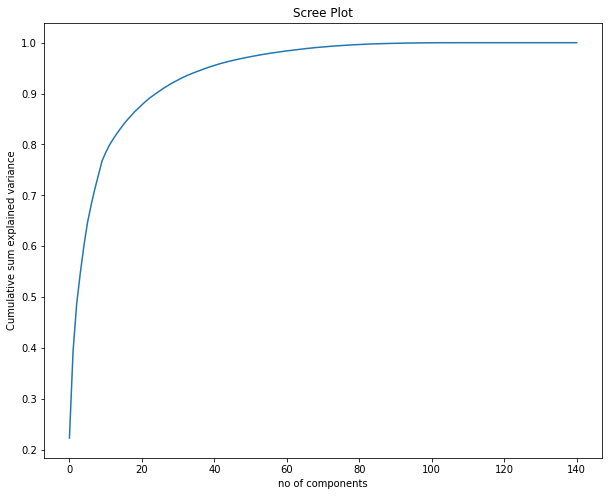

In [97]:
#Making a screeplot to plot the cumulative variance against no of components
plt.figure(figsize=(10,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('no of components')
plt.ylabel('Cumulative sum explained variance')
plt.title('Scree Plot')
plt.show()

39 variables explain more than 95% of variance in our dataset.So we choose these 40 variables to build our incremental pca model

In [98]:
#Building a incrementalPCA using 39 variables
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=39)
model_pca_final = pca_final.fit(X_train,y_train)

In [99]:
X_train_pca = model_pca_final.fit_transform(X_train)
X_train_pca.shape

(23664, 39)

In [100]:
#Applying PCA on X_test
X_test_pca = model_pca_final.transform(X_test)
X_test_pca.shape

(5916, 39)

## Checking for class imbalance


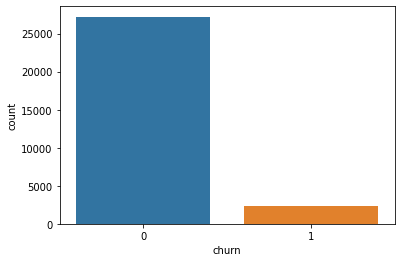

In [101]:
 sns.countplot(x=df.churn ,data=df,)

        

In [102]:
df.churn.value_counts(normalize=True)

0    0.920047
1    0.079953
Name: churn, dtype: float64

Our dataset is highly imbalanced with 92%  --> 0 indicating with no Churn
                                       8%  --> 1 indicating Churn

In order to get accurate predictions we will deal with class imbalance using weighted class.
This can be achieved by giving different weights to both the majority and minority classes. The difference in weights will influence the classification of the classes during the training phase. The whole purpose is to penalize the misclassification made by the minority class by setting a higher class weight and at the same time reducing weight for the majority class.

# Build model to predict customers who will churn - with PCA 

## Logistic Regression

In [110]:
#We will use weighted class technique to handle class imbalance
#Finding the weight to be assigned to each class manually using gridsearchcv
from sklearn.model_selection import RandomizedSearchCV
lr = LogisticRegression(random_state=42)
lr = lr.fit(X_train_pca, y_train)

# Predicting on the test data
pred_test = lr.predict(X_test_pca)

#Setting range for class range
weights = np.linspace(0.0,0.99,200)

param_grid = { 'class_weight' : ({0: 0.17, 1: 0.82},{0: 0.30, 1: 0.70}),
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']
              }

#Fitting grid search to the train data with 5 folds
gridsearch = RandomizedSearchCV(estimator= lr, 
                          param_distributions= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='recall', 
                          verbose=2).fit(X_train_pca, y_train)

'''#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)'''

Fitting 5 folds for each of 10 candidates, totalling 50 fits


"#Ploting the score for different values of weight\nsns.set_style('whitegrid')\nplt.figure(figsize=(12,8))\nweigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})\nsns.lineplot(weigh_data['weight'], weigh_data['score'])\nplt.xlabel('Weight for class 1')\nplt.ylabel('F1 score')\nplt.xticks([round(i/10,1) for i in range(0,11,1)])\nplt.title('Scoring for different class weights', fontsize=24)"

We got 0.82 as highest value for weight of our minority class i.e 1 and 0.17 for class 0

In [111]:
gridsearch.best_estimator_

LogisticRegression(C=206.913808111479, class_weight={0: 0.17, 1: 0.82},
                   penalty='l1', random_state=42, solver='liblinear')

In [112]:
from sklearn.metrics import f1_score,confusion_matrix,classification_report
lr = LogisticRegression(solver='newton-cg', random_state=42, class_weight={0: 0.17909547738693468, 1: 0.8209045226130653})
logreg = lr.fit(X_train_pca, y_train)

# Predicting on the test data
pred_test = logreg.predict(X_test_pca)
pred_train = logreg.predict(X_train_pca)

#Calculating and printing the f1 score 
f1_test = f1_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)

#Ploting the confusion matrix
print('Confusion Matrix',confusion_matrix(y_test, pred_test),end=' ')
print('Classification Report for train data ')
print(classification_report(y_train, pred_train))
print('Classification Report for test data ')
print(classification_report(y_test, pred_test))

The f1 score for the testing data: 0.4956521739130435
Confusion Matrix [[5051  392]
 [ 188  285]] Classification Report for train data 
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     21772
           1       0.44      0.61      0.51      1892

    accuracy                           0.91     23664
   macro avg       0.70      0.77      0.73     23664
weighted avg       0.92      0.91      0.91     23664

Classification Report for test data 
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      5443
           1       0.42      0.60      0.50       473

    accuracy                           0.90      5916
   macro avg       0.69      0.77      0.72      5916
weighted avg       0.92      0.90      0.91      5916



Here we get approx same recall of 0.60  for train and test data, also the accuracy of 90% is same.

In [ ]:
confusion = confusion_matrix(y_test, pred_test)
TP, TN,FP, FN  = confusion[1,1], confusion[0,0], confusion[0,1], confusion[1,0]  
sensitivity = TP/float (TP+FN); sensitivity=round(sensitivity*100,2)
specificity = TN/float (TN+FP); specificity = round(specificity*100,2)
fpr = FP/float(TN+FP); fpr = round(fpr*100,2)
ppv = TP/float(TP+FP); ppv = round(ppv*100,2)

In [ ]:
print('Sensitivity',sensitivity)

In [ ]:
from sklearn import metrics
print('roc_auc_score' , metrics.roc_auc_score(y_test, pred_test))

We can see for the Logistic model with PCA on test data :
             -> Sensitivty is 46.72
             -> Roc_auc score is 0.69
The above values indicate our model is not giving very good results.
So we will try another approach for prediction.


## XGBoost with PCA

Boosters turn weak learners into strong learners by focusing on where the individual models (usually Decision Trees) went wrong. In Gradient Boosting, individual models train upon the residuals, the difference between the prediction and the actual results. Instead of aggregating trees, gradient boosted trees learns from errors during each boosting round.
XGBoost is short for “eXtreme Gradient Boosting.” The “eXtreme” refers to speed enhancements such as parallel computing and cache awareness that makes XGBoost approximately 10 times faster than traditional Gradient Boosting. In addition, XGBoost includes a unique split-finding algorithm to optimize trees, along with built-in regularization that reduces overfitting. Generally speaking, XGBoost is a faster, more accurate version of Gradient Boosting.

In [119]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score,KFold

In [120]:
xgb = XGBClassifier()
print(xgb)

XGBClassifier()


In [121]:
#Fitting the model on train data
xgb.fit(X_train_pca,y_train)

XGBClassifier()

In [122]:
#Checking cross validation score
score = cross_val_score(xgb,X_train_pca,y_train,cv=5)
score

array([0.92605113, 0.91865624, 0.92731883, 0.9264737 , 0.92878276])

In [123]:
print("Mean cross-validation score: %.2f" % score.mean())

Mean cross-validation score: 0.93


In [160]:
pred_train_proba = xgb.predict_proba(X_train_pca)[:,1]
pred_test_proba = xgb.predict_proba(X_test_pca)[:,1]
test_proba = xgb.predict(X_test_pca)

In [125]:
print('roc_auc score on train data by XGBoost default',metrics.roc_auc_score(y_train,pred_train_proba))
print('roc_auc score on test data by XGBoost default',metrics.roc_auc_score(y_test,pred_test_proba))

roc_auc score on train data by XGBoost default 0.9157049208615602
roc_auc score on test data by XGBoost default 0.8850073741357191


In [162]:
print(classification_report(y_test,test_proba))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5443
           1       0.58      0.18      0.28       473

    accuracy                           0.92      5916
   macro avg       0.76      0.59      0.62      5916
weighted avg       0.90      0.92      0.91      5916



We are getting a very low recall of 0.18 .Lets improve the performance by hyperpzrameter tuning

In [227]:
### Hyperparameter tuning for XGBoost
#Using scale_pos_weight to handle class imbalance in dataset


from sklearn.model_selection import RandomizedSearchCV

parameters = {'learning_rate' :[0.2,0.5,0.6,0.7],
              'n_estimators' : range(1,200,20),
              'scale_pos_weight' : [10,60,90],
              'max_depth' : range(1,200,20),
              'colsample_bytree' :[0.2,0.5,0.6,0.7],
              'subsample' : [0.2,0.4,0.5,0.6]
             }


xgb_tuned1 = RandomizedSearchCV(estimator = xgb,
                          param_distributions = parameters,
                          scoring='recall',
                          n_jobs  = -1,
                          return_train_score  = True,
                          cv = 5,
                          refit = True
                          )



In [226]:
'''parameters = parameters = {'learning_rate' :[0.2,0.5,0.6,0.7],
              'n_estimators' : range(1,200,20),
              'scale_pos_weight' : [10,60,90],
              'max_depth' : range(1,200,20),
              'colsample_bytree' :[0.2,0.5,0.6,0.7],
              'subsample' : [0.2,0.4,0.5,0.6]
             }
'''

"parameters = parameters = {'learning_rate' :[0.2,0.5,0.6,0.7],\n              'n_estimators' : range(1,200,20),\n              'scale_pos_weight' : [10,60,90],\n              'max_depth' : range(1,200,20),\n              'colsample_bytree' :[0.2,0.5,0.6,0.7],\n              'subsample' : [0.2,0.4,0.5,0.6]\n             }\n"

In [228]:
xgb_tuned1.fit(X_train_pca,y_train)


RandomizedSearchCV(cv=5, estimator=XGBClassifier(), n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.2, 0.5, 0.6,
                                                             0.7],
                                        'learning_rate': [0.2, 0.5, 0.6, 0.7],
                                        'max_depth': range(1, 200, 20),
                                        'n_estimators': range(1, 200, 20),
                                        'scale_pos_weight': [10, 60, 90],
                                        'subsample': [0.2, 0.4, 0.5, 0.6]},
                   return_train_score=True, scoring='recall')

In [229]:
cv_results = pd.DataFrame(xgb_tuned1.cv_results_)
cv_results[['param_learning_rate','param_n_estimators','mean_train_score','mean_test_score','rank_test_score']]

,param_learning_rate,param_n_estimators,mean_train_score,mean_test_score,rank_test_score
0,0.6,41,1.000000,0.352548,9
1,0.7,21,0.829545,0.671826,3
2,0.2,141,1.000000,0.396423,7
3,0.7,101,0.933013,0.903260,1
4,0.2,1,0.549415,0.257960,10
5,0.5,121,0.956275,0.547218,4
6,0.6,21,0.998811,0.376856,8
7,0.6,61,0.909749,0.885326,2
8,0.2,1,0.808800,0.487852,5
9,0.6,121,0.997358,0.475837,6


In [230]:
xgb_tuned1.best_estimator_

XGBClassifier(colsample_bytree=0.5, learning_rate=0.7, max_depth=41,
              n_estimators=101, scale_pos_weight=90, subsample=0.5)

We get the hypertuned XGBoost model with  learning_rate=0.3 
                                          max_depth=6
                                          n_estimators=40
                                          scale_pos_weight=0.4

In [217]:
#Predicting on test data
xgb_test_pred = xgb_tuned1.predict(X_test_pca)

In [233]:
print(classification_report(y_test,xgb_test_pred))

              precision    recall  f1-score   support

           0       0.99      0.45      0.62      5443
           1       0.13      0.96      0.23       473

    accuracy                           0.49      5916
   macro avg       0.56      0.71      0.43      5916
weighted avg       0.92      0.49      0.59      5916



In [234]:
print('roc_auc_score',metrics.roc_auc_score(y_test,xgb_test_pred))

roc_auc_score 0.707087948560888


We are getting a very low recall of 0.04 on our target class 1 .Which means our model is predicting non churn more accurately than predicting churn which is not our requirement.

Also the auc_roc score is 0.51 which is pretty low.

XGBoost wont be a good fit for our use case.

## Random Forest

Default Model

In [221]:
from sklearn.ensemble import RandomForestClassifier

In [222]:
random_forest = RandomForestClassifier(random_state = 42,class_weight = {0:0.17 , 1:0.82})
random_forest.fit(X_train_pca,y_train)

RandomForestClassifier(class_weight={0: 0.17, 1: 0.82}, random_state=42)

Random Forest - Train Confusion Matrix:
TP: 1892, TN: 21772, FP:0, FN:0
[[21772     0]
 [    0  1892]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21772
           1       1.00      1.00      1.00      1892

    accuracy                           1.00     23664
   macro avg       1.00      1.00      1.00     23664
weighted avg       1.00      1.00      1.00     23664

Accuracy: % 100.0 Sensitivity: 100.0% Specificity: 100.0% Precision: 100.0% Recall: 100.0% FPR: 0.0% PPV: 100.0%


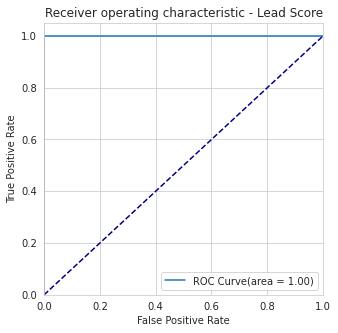

Random Forest - Test Confusion Matrix:
TP: 71, TN: 5400, FP:43, FN:402
[[5400   43]
 [ 402   71]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5443
           1       0.62      0.15      0.24       473

    accuracy                           0.92      5916
   macro avg       0.78      0.57      0.60      5916
weighted avg       0.91      0.92      0.90      5916

Accuracy: % 92.48 Sensitivity: 15.01% Specificity: 99.21% Precision: 62.28% Recall: 15.01% FPR: 0.79% PPV: 62.28%


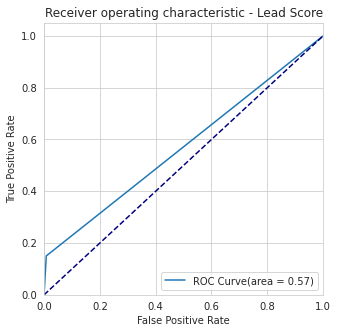

In [223]:
## Evaluating on train data
y_train_predicted = random_forest.predict(X_train_pca)
_ = evaluate_classification_model('Random Forest - Train', [], y_train, y_train_predicted)

# Evaluating on test data
y_test_predicted = random_forest.predict(X_test_pca)
#print(classification_report(y_test, xrf_test_pred))
_ = evaluate_classification_model('Random Forest - Test', [], y_test, y_test_predicted)

With the default model we are getting 14% recall for class 1. Lets check after tuning hyperparameters.

Model with Hyper Parameter tuning

In [224]:
from sklearn.model_selection import RandomizedSearchCV

def runRandomForest(random_forest, X_test, y_test_actual, params, scoring):
    rf_cv = RandomizedSearchCV(estimator = random_forest,
                                    param_distributions = params,
                                    scoring=scoring, random_state = 42
                                    )
    rf_cv.fit(X_train_pca,y_train)
    print("Best Score", rf_cv.best_score_, "Best Estimator:", rf_cv.best_estimator_)

    # Evaluating on train data
    y_train_predicted = rf_cv.predict(X_train_pca)
    _ = evaluate_classification_model('Random Forest - Train', [], y_train, y_train_predicted)

    # Evaluating on test data
    y_test_predicted = rf_cv.predict(X_test)
    #print(classification_report(y_test, xrf_test_pred))
    _ = evaluate_classification_model('Random Forest - Test', [], y_test_actual, y_test_predicted)

    params_ = [f'param_{param}' for param in params.keys()]
    cv_results = pd.DataFrame(rf_cv.cv_results_)
    cols_cv = list(params_) + ['mean_test_score','rank_test_score']
    cv_results[cols_cv].sort_values(by='rank_test_score').head()

    for param in params_:
        if param == 'param_class_weight': continue
        cv_results[[param,'mean_test_score']].groupby(by=param).agg({'mean_test_score':np.mean}).plot.line()
        print()

Best Score 0.8261213720316622 Best Estimator: RandomForestClassifier(class_weight={0: 0.05, 1: 0.95}, max_depth=20,
                       max_features=18, min_samples_leaf=155, n_estimators=120,
                       random_state=42)
Random Forest - Train Confusion Matrix:
TP: 1698, TN: 16891, FP:4881, FN:194
[[16891  4881]
 [  194  1698]]
              precision    recall  f1-score   support

           0       0.99      0.78      0.87     21772
           1       0.26      0.90      0.40      1892

    accuracy                           0.79     23664
   macro avg       0.62      0.84      0.64     23664
weighted avg       0.93      0.79      0.83     23664

Accuracy: % 78.55 Sensitivity: 89.75% Specificity: 77.58% Precision: 25.81% Recall: 89.75% FPR: 22.42% PPV: 25.81%


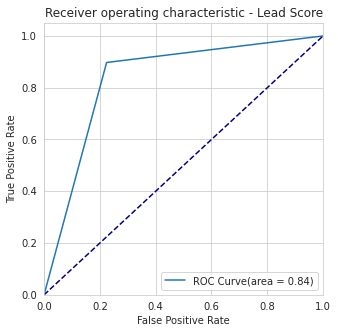

Random Forest - Test Confusion Matrix:
TP: 384, TN: 4212, FP:1231, FN:89
[[4212 1231]
 [  89  384]]
              precision    recall  f1-score   support

           0       0.98      0.77      0.86      5443
           1       0.24      0.81      0.37       473

    accuracy                           0.78      5916
   macro avg       0.61      0.79      0.62      5916
weighted avg       0.92      0.78      0.82      5916

Accuracy: % 77.69 Sensitivity: 81.18% Specificity: 77.38% Precision: 23.78% Recall: 81.18% FPR: 22.62% PPV: 23.78%


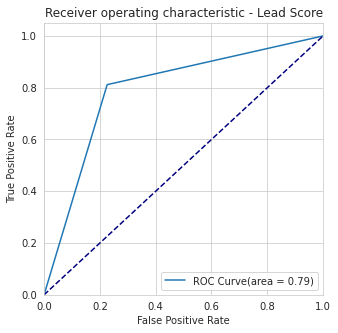

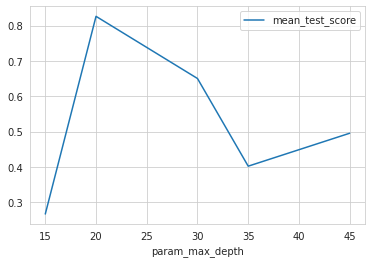

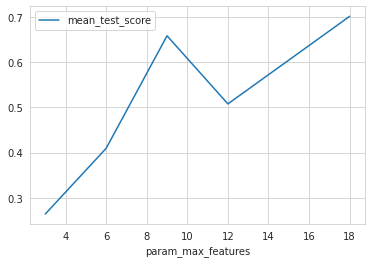

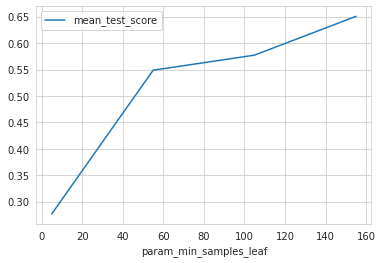

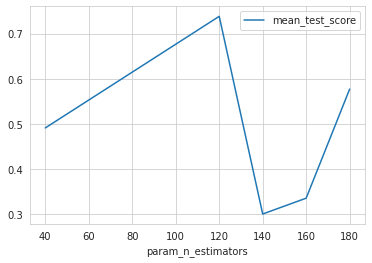

In [225]:
random_forest = RandomForestClassifier(random_state = 42)
params = {  'max_depth':    range(5, 50, 5),
            'max_features': range(3, 21, 3),
            'min_samples_leaf': range(5,200,50),
            'n_estimators' : range(20, 200, 20),
            'class_weight' : [{0:0.05 , 1:0.95}, {0:0.1 , 1:0.90},{0:0.15 , 1:0.85}, {0:0.18 , 1:0.82}]
          }
runRandomForest(random_forest, X_test_pca, y_test, params, 'recall' )

For models with PCA following is performance on test data:

*   Logistic Regresion - Recall 0.60 , Accuracy 0.90
*   XGBoost - Recall 0.96 , Accuracy 0.47
*   Random Forest - Recall 0.81 , Accuracy 0.78

So we conclude Random Forest to be the best model for our prediction with PCA.








# Build model to identify indicators of churn - w/o PCA

## Logistic Regression

### Build Model

In [ ]:
# Make a copy of the training and test data sets
X_train_1 = X_train.copy(); y_train_1 = y_train.copy()
X_test_1 = X_test.copy();   y_test_1 = y_test.copy()

In [ ]:
# Build a Logistic regression model
logreg = sm.GLM(y_train_1,(sm.add_constant(X_train_1)), family = sm.families.Binomial())
logreg.fit().summary()

logreg_2, X_train_sm_2 = dropColumnAndBuildModel(X_train_1, y_train_1)

141
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                23664
Model:                            GLM   Df Residuals:                    23538
Model Family:                Binomial   Df Model:                          125
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4015.6
Date:                Mon, 03 Jan 2022   Deviance:                       8031.2
Time:                        16:26:01   Pearson chi2:                 1.03e+06
No. Iterations:                    66                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               4619.7233   

In [ ]:
# Run RFE and then build the model
features_1 = runRFE(15, X_train_1, y_train_1 )
X_train_1  = X_train_1[features_1]
lr_model_1, X_train_sm_1 = dropColumnAndBuildModel(X_train_1, y_train_1)

Columns selected by RFE: 15 ['std_og_mou_8', 'monthly_3g_8', 'total_ic_mou_8', 'total_rech_amt_6', 'total_mou_8', 'total_mou_78', 'monthly_2g_8', 'arpu_78', 'vol_mb_8', 'total_rech_num_8', 'total_og_mou_8', 'last_day_rch_amt_8', 'sachet_2g_8', 'roam_og_mou_7', 'max_rech_amt_8']
Columns dropped by RFE: 126 ['loc_og_t2c_mou_8', 'loc_og_t2m_mou_8', 'max_rech_amt_7', 'std_ic_mou_7', 'ic_others_6', 'total_mou_6', 'ic_others_7', 'max_rech_amt_6', 'aug_vbc_3g', 'sep_vbc_3g', 'avg_rech_amt_67', 'vol_3g_mb_8', 'monthly_3g_6', 'vol_2g_mb_8', 'loc_og_t2c_mou_7', 'std_ic_mou_6', 'isd_ic_mou_6', 'sachet_3g_8', 'arpu', 'loc_og_mou_6', 'total_mou_7', 'std_ic_t2f_mou_8', 'onnet_mou_7', 'roam_ic_mou_8', 'roam_ic_mou_6', 'std_ic_t2t_mou_7', 'loc_og_t2t_mou_7', 'spl_og_mou_8', 'std_og_t2f_mou_8', 'vol_2g_mb_7', 'monthly_2g_7', 'total_rech_num_7', 'offnet_mou_8', 'std_ic_mou_8', 'loc_ic_t2t_mou_7', 'aon', 'loc_ic_t2m_mou_6', 'loc_ic_t2f_mou_7', 'og_others_7', 'vol_2g_mb_6', 'roam_og_mou_6', 'last_day_rch_

RFE selected 15 columns. Now we can perform manual elimination of features with high VIF and/or p-value > 0.05

In [ ]:
# total_mou_8 has a high VIF. So let's drop this and build the model
lr_model_1, X_train_sm_1 = dropColumnAndBuildModel(X_train_1, y_train_1, col='total_mou_8')

15
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                23664
Model:                            GLM   Df Residuals:                    23649
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4475.9
Date:                Mon, 03 Jan 2022   Deviance:                       8951.9
Time:                        16:27:26   Pearson chi2:                 2.39e+07
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  5.5749    

In [ ]:
# max_rech_amt_8 has a p-value > 0.05. So let's drop this and build the model
lr_model_1, X_train_sm_1 = dropColumnAndBuildModel(X_train_1, y_train_1, col='max_rech_amt_8')

14
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                23664
Model:                            GLM   Df Residuals:                    23650
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4476.5
Date:                Mon, 03 Jan 2022   Deviance:                       8952.9
Time:                        16:27:26   Pearson chi2:                 2.01e+07
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  5.5621    

In [ ]:
# total_mou_78 has a high VIF. So let's drop this and build the model
lr_model_1, X_train_sm_1 = dropColumnAndBuildModel(X_train_1, y_train_1, col='total_mou_78')

13
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                23664
Model:                            GLM   Df Residuals:                    23651
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4534.8
Date:                Mon, 03 Jan 2022   Deviance:                       9069.5
Time:                        16:27:26   Pearson chi2:                 1.15e+08
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 10.9346    

In [ ]:
# total_og_mou_8 has a high VIF. So let's drop this and build the model
lr_model_1, X_train_sm_1 = dropColumnAndBuildModel(X_train_1, y_train_1, col='total_og_mou_8')

12
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                23664
Model:                            GLM   Df Residuals:                    23652
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4667.7
Date:                Mon, 03 Jan 2022   Deviance:                       9335.4
Time:                        16:27:27   Pearson chi2:                 9.09e+06
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 12.9420    

In [ ]:
# Get the list of columns in the model
cols_dropped = list(set(features_1) - set(X_train_1.columns))
print("All Features", len(features_1), features_1, "\nDropped Features", len(cols_dropped), cols_dropped)
features_1 = X_train_1.columns.tolist()
print("Features in the model", len(features_1), features_1)

All Features 15 ['std_og_mou_8', 'monthly_3g_8', 'total_ic_mou_8', 'total_rech_amt_6', 'total_mou_8', 'total_mou_78', 'monthly_2g_8', 'arpu_78', 'vol_mb_8', 'total_rech_num_8', 'total_og_mou_8', 'last_day_rch_amt_8', 'sachet_2g_8', 'roam_og_mou_7', 'max_rech_amt_8'] 
Dropped Features 4 ['total_mou_78', 'max_rech_amt_8', 'total_mou_8', 'total_og_mou_8']
Features in the model 11 ['std_og_mou_8', 'monthly_3g_8', 'total_ic_mou_8', 'total_rech_amt_6', 'monthly_2g_8', 'arpu_78', 'vol_mb_8', 'total_rech_num_8', 'last_day_rch_amt_8', 'sachet_2g_8', 'roam_og_mou_7']


### Evaluate Model

#### Training dataset

In [ ]:
print(features_1)

['std_og_mou_8', 'monthly_3g_8', 'total_ic_mou_8', 'total_rech_amt_6', 'monthly_2g_8', 'arpu_78', 'vol_mb_8', 'total_rech_num_8', 'last_day_rch_amt_8', 'sachet_2g_8', 'roam_og_mou_7']


       Actual      Prob     ID  Predicted
18269       0  0.000214  18269          0
27430       0  0.014417  27430          0
25109       0  0.000384  25109          0
19152       0  0.090219  19152          0
9587        0  0.004197   9587          0

Logistic Regression - TRAIN - o.5 cut-off Confusion Matrix:
TP: 304, TN: 21611, FP:161, FN:1588
[[21611   161]
 [ 1588   304]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     21772
           1       0.65      0.16      0.26      1892

    accuracy                           0.93     23664
   macro avg       0.79      0.58      0.61     23664
weighted avg       0.91      0.93      0.90     23664

Accuracy: % 92.61 Sensitivity: 16.07% Specificity: 99.26% Precision: 65.38% Recall: 16.07% FPR: 0.74% PPV: 65.38%


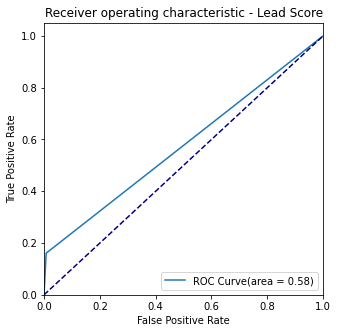

In [ ]:
# Predict using probability of 0.5 and evaluate the model
y_train_pred_final_1 = predict(lr_model_1, X_train_sm_1, y_train_1); print()
_ = evaluate_classification_model("Logistic Regression - TRAIN - o.5 cut-off", features_1, y_train_pred_final_1['Actual'], y_train_pred_final_1['Predicted'])

     prob  accuracy     sensi     speci
0.0   0.0  0.079953  1.000000  0.000000
0.1   0.1  0.823698  0.788584  0.826750
0.2   0.2  0.905426  0.662791  0.926511
0.3   0.3  0.927823  0.549683  0.960683
0.4   0.4  0.930992  0.342495  0.982133
0.5   0.5  0.926090  0.160677  0.992605
0.6   0.6  0.923343  0.081924  0.996463
0.7   0.7  0.921780  0.040698  0.998347
0.8   0.8  0.921231  0.020613  0.999495
0.9   0.9  0.920554  0.008457  0.999816


<Figure size 720x720 with 0 Axes>

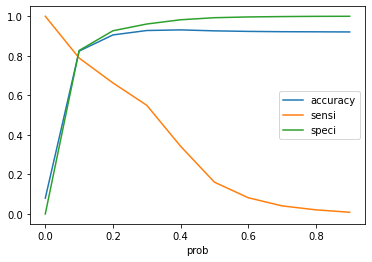

,Actual,Prob,ID,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
18269,0,0.000214,18269,0,1,0,0,0,0,0,0,0,0,0
27430,0,0.014417,27430,0,1,0,0,0,0,0,0,0,0,0
25109,0,0.000384,25109,0,1,0,0,0,0,0,0,0,0,0
19152,0,0.090219,19152,0,1,0,0,0,0,0,0,0,0,0
9587,0,0.004197,9587,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
# Predict the evaluate the model for various cut-offs
predAndEvaluateForVariousCutoffs(y_train_pred_final_1)

From the plot, the optimal cut- off is 0.1

Logistic Regression - TRAIN - Optimum cut-off Confusion Matrix:
TP: 1492, TN: 18000, FP:3772, FN:400
[[18000  3772]
 [  400  1492]]
              precision    recall  f1-score   support

           0       0.98      0.83      0.90     21772
           1       0.28      0.79      0.42      1892

    accuracy                           0.82     23664
   macro avg       0.63      0.81      0.66     23664
weighted avg       0.92      0.82      0.86     23664

Accuracy: % 82.37 Sensitivity: 78.86% Specificity: 82.67% Precision: 28.34% Recall: 78.86% FPR: 17.33% PPV: 28.34%


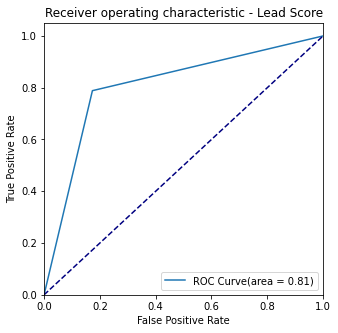

In [ ]:
OPTIMUM_CUTOFF = 0.1

# Predict the class using the optinal cut-off
_ = evaluate_classification_model("Logistic Regression - TRAIN - Optimum cut-off", features_1, y_train_pred_final_1['Actual'], y_train_pred_final_1[OPTIMUM_CUTOFF])

ROC on the training dataset is 81%. Recall/Sensitivity is 79%

#### Test dataset

In [ ]:
# Get the test data set for only the selected features
X_test_1 = X_test_1[features_1]
X_test_1.head()

,std_og_mou_8,monthly_3g_8,total_ic_mou_8,total_rech_amt_6,monthly_2g_8,arpu_78,vol_mb_8,total_rech_num_8,last_day_rch_amt_8,sachet_2g_8,roam_og_mou_7
11779,0.133541,0.0,0.007897,0.022486,0.0,0.475334,0.000000,0.030612,0.037986,0.0,0.000000
20181,0.000000,0.0,0.000000,0.036162,0.0,0.465125,0.000000,0.025510,0.029220,0.0,0.035967
2253,0.003231,0.0,0.143821,0.063081,0.0,0.504611,0.000000,0.020408,0.123623,0.0,0.000000
21616,0.003495,0.0,0.022850,0.036703,0.0,0.497092,0.000000,0.025510,0.056192,0.0,0.000000
2153,0.320230,0.0,0.033058,0.059838,0.8,0.498270,0.250039,0.112245,0.011238,0.0,0.000000


12 ['const', 'std_og_mou_8', 'monthly_3g_8', 'total_ic_mou_8', 'total_rech_amt_6', 'monthly_2g_8', 'arpu_78', 'vol_mb_8', 'total_rech_num_8', 'last_day_rch_amt_8', 'sachet_2g_8', 'roam_og_mou_7']
       Actual      Prob     ID  Predicted
11779       0  0.069220  11779          0
20181       0  0.256727  20181          1
2253        0  0.000057   2253          0
21616       0  0.023299  21616          0
2153        0  0.000010   2153          0
Logistic Regression - TEST Confusion Matrix:
TP: 372, TN: 4505, FP:938, FN:101
[[4505  938]
 [ 101  372]]
              precision    recall  f1-score   support

           0       0.98      0.83      0.90      5443
           1       0.28      0.79      0.42       473

    accuracy                           0.82      5916
   macro avg       0.63      0.81      0.66      5916
weighted avg       0.92      0.82      0.86      5916

Accuracy: % 82.44 Sensitivity: 78.65% Specificity: 82.77% Precision: 28.4% Recall: 78.65% FPR: 17.23% PPV: 28.4%


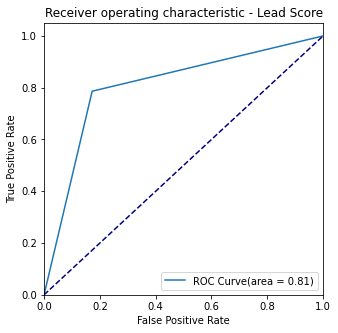

In [ ]:
## Predict using the optimum cut-off
X_test_sm_1 = sm.add_constant(X_test_1)
print(len(X_test_sm_1.columns.tolist()), X_test_sm_1.columns.tolist())
y_test_pred_final_1 =  predict(lr_model_1, X_test_sm_1, y_test_1, OPTIMUM_CUTOFF)

# Evaluate the model on test data set
_ = evaluate_classification_model("Logistic Regression - TEST", features_1, y_test_pred_final_1['Actual'], y_test_pred_final_1['Predicted'])

The accuracy and sensitivity/recall values are decent but the number of features is still a little high (11). Let's build another model (decision tree) and check

## Decision Tree

### Imports and Functions

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Importing required packages for visualization
from IPython.display import Image  
from six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz

from graphviz import Source
def get_dt_graph(dt_classifier, X):
    dot_data = StringIO()
    export_graphviz(dt_classifier, out_file=dot_data, filled=True, rounded=True, feature_names=X.columns, class_names=['Not Churned', 'Churned'])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    graph.set_size('"20,50!"')
    graph.write_png('dt.png')
    return graph.create_png()

### Prepare Data
No scaling of data is needed for Decistion Trees as Decistion Trees is scale invariant. Also the decisions (conditions) will not be intuitive if the data is scaled.

In [ ]:
# Split df into train and test.

# Note: Use ```stratify``` to preserve the poportion of the target variable churn=1 & churn=0 in train and test datasets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df[COL_TARGET])

# Create X_train & y_train
print("TRAIN:", df_train.shape,"\n", df_train[COL_TARGET].value_counts(normalize=True)*100)
X_train_4 = df_train[list(set(COLS)-set([COL_TARGET]))]
y_train_4 = df_train[COL_TARGET]
print(f"X_train: {X_train_4.shape} {type(X_train_4)}")
print(f"y_train:  {y_train_4.shape} {type(y_train_4)}", "\n")

# Create X_test & y_test
print("TEST:" , df_test.shape, "\n", df_test[COL_TARGET].value_counts(normalize=True)*100)
X_test_4 = df_test[list(set(COLS)-set([COL_TARGET]))]
y_test_4 = df_test[COL_TARGET]
print(f"X_test: {X_test_4.shape} {type(X_test_4)}")
print(f"y_test: {y_test_4.shape} {type(y_test_4)}")

X_train_4.head()

TRAIN: (23664, 142) 
 0    92.004733
1     7.995267
Name: churn, dtype: float64
X_train: (23664, 141) <class 'pandas.core.frame.DataFrame'>
y_train:  (23664,) <class 'pandas.core.series.Series'> 

TEST: (5916, 142) 
 0    92.004733
1     7.995267
Name: churn, dtype: float64
X_test: (5916, 141) <class 'pandas.core.frame.DataFrame'>
y_test: (5916,) <class 'pandas.core.series.Series'>


,loc_og_t2c_mou_8,loc_og_t2m_mou_8,max_rech_amt_7,std_og_mou_8,std_ic_mou_7,ic_others_6,total_mou_6,ic_others_7,aug_vbc_3g,max_rech_amt_6,...,vol_3g_mb_6,roam_og_mou_7,loc_og_t2f_mou_6,max_rech_amt_8,total_rech_num_6,sachet_2g_6,loc_ic_mou_8,std_og_t2t_mou_6,loc_ic_t2f_mou_6,isd_ic_mou_7
18269,5.21,115.43,145,25.59,5.74,0.00,262.64,0.18,191.23,120,...,10047.52,0.00,1.43,150,4,0,90.86,15.2,4.49,0.00
27430,0.00,206.63,110,80.94,85.88,0.00,525.44,0.00,0.00,110,...,0.00,0.00,1.59,130,7,0,255.08,0.0,0.00,2.16
25109,0.00,170.54,252,86.48,11.50,0.00,1372.32,0.00,1876.42,252,...,3557.14,0.00,16.81,252,8,0,636.84,0.0,17.81,0.00
19152,0.00,195.64,325,0.00,4.60,0.03,788.02,2.30,0.00,120,...,0.00,0.00,3.93,150,5,0,284.81,0.0,5.18,0.00
9587,0.00,0.00,1000,0.00,0.00,0.00,0.00,0.00,3362.35,655,...,4377.85,538.96,0.00,655,7,0,0.00,0.0,0.00,0.00


### Build Model

In [ ]:
# Create the parameter grid based on the results of random search 
# If 5 and 10 are included in max_depth, the best estimator has depth of 10 and the interpretation of the model was difficult. 
# So using only the values of 2,3 4
params = {
    'max_depth': [2, 3, 4,], #5,# 10], 
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"],
}

# Instantiate the grid search model. Here we will use 
# - the class weights identified earlier  
# - recall as the scoring algorithm
dt = DecisionTreeClassifier(random_state=42, class_weight={0: 0.18, 1: 0.82})
grid_search = GridSearchCV(estimator=dt, param_grid=params, cv=4, n_jobs=-1, verbose=1, scoring = "recall")
grid_search

GridSearchCV(cv=4,
             estimator=DecisionTreeClassifier(class_weight={0: 0.18, 1: 0.82},
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='recall', verbose=1)

In [ ]:
%%time
# Perform the search for finding the optimum hyper parameters
grid_search.fit(X_train_4, y_train_4)

Fitting 4 folds for each of 30 candidates, totalling 120 fits
CPU times: user 1.35 s, sys: 246 ms, total: 1.6 s
Wall time: 12.8 s


GridSearchCV(cv=4,
             estimator=DecisionTreeClassifier(class_weight={0: 0.18, 1: 0.82},
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='recall', verbose=1)

In [ ]:
# Get the grid search results
df_score = pd.DataFrame(grid_search.cv_results_); df_score.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,1.150362,0.010052,0.040463,0.012881,gini,2,5,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.513742,0.534884,0.511628,0.541226,0.52537,0.012903,26
1,1.153861,0.008031,0.040731,0.014332,gini,2,10,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.513742,0.534884,0.511628,0.541226,0.52537,0.012903,26
2,1.151507,0.001928,0.044049,0.003980,gini,2,20,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.513742,0.534884,0.511628,0.541226,0.52537,0.012903,26
3,1.149547,0.001418,0.044448,0.008200,gini,2,50,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.513742,0.534884,0.511628,0.541226,0.52537,0.012903,26
4,0.687776,0.056484,0.016136,0.002647,gini,2,100,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.513742,0.534884,0.511628,0.541226,0.52537,0.012903,26


In [ ]:
# View the results with highest test scores 
df_score.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
5,0.880688,0.004723,0.014299,0.001398,gini,3,5,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.693446,0.718816,0.625793,0.725159,0.690803,0.039365,1
6,0.866659,0.005084,0.016294,0.001715,gini,3,10,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.693446,0.718816,0.625793,0.725159,0.690803,0.039365,1
7,0.841066,0.005297,0.017893,0.004229,gini,3,20,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.693446,0.718816,0.625793,0.725159,0.690803,0.039365,1
8,0.868404,0.017575,0.025297,0.003362,gini,3,50,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.693446,0.718816,0.625793,0.725159,0.690803,0.039365,1
9,0.975561,0.016453,0.018892,0.002491,gini,3,100,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.693446,0.714588,0.625793,0.725159,0.689746,0.038649,5


In [ ]:
# Get the best estimator
dt_best = grid_search.best_estimator_; print(dt_best)

# Get the feature importances
df_fi = pd.DataFrame({"Features": X_train_4.columns.to_list(),"Importance": dt_best.feature_importances_})
features_4 = df_fi.sort_values(by='Importance', ascending=False).head(6); print(features_4)
features_4 = features_4['Features'].tolist()

DecisionTreeClassifier(class_weight={0: 0.18, 1: 0.82}, max_depth=3,
                       min_samples_leaf=5, random_state=42)
               Features  Importance
48       total_ic_mou_8    0.758964
96        roam_og_mou_8    0.124485
95              arpu_78    0.048977
57          total_mou_8    0.037561
122  last_day_rch_amt_8    0.016368
12          vol_3g_mb_8    0.013645


### Evaluate Model

Decision Tree - HPT - TRAIN Confusion Matrix:
TP: 1351, TN: 19840, FP:1932, FN:541
[[19840  1932]
 [  541  1351]]
              precision    recall  f1-score   support

           0       0.97      0.91      0.94     21772
           1       0.41      0.71      0.52      1892

    accuracy                           0.90     23664
   macro avg       0.69      0.81      0.73     23664
weighted avg       0.93      0.90      0.91     23664

Accuracy: % 89.55 Sensitivity: 71.41% Specificity: 91.13% Precision: 41.15% Recall: 71.41% FPR: 8.87% PPV: 41.15%


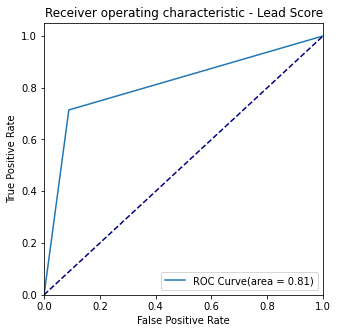

Decision Tree - HPT - TEST Confusion Matrix:
TP: 322, TN: 4975, FP:468, FN:151
[[4975  468]
 [ 151  322]]
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      5443
           1       0.41      0.68      0.51       473

    accuracy                           0.90      5916
   macro avg       0.69      0.80      0.73      5916
weighted avg       0.93      0.90      0.91      5916

Accuracy: % 89.54 Sensitivity: 68.08% Specificity: 91.4% Precision: 40.76% Recall: 68.08% FPR: 8.6% PPV: 40.76%


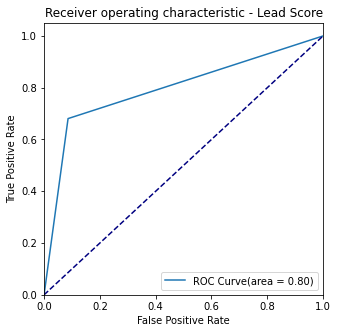

In [ ]:
# Evaluate the model wrt training and test datasets
y_train_predicted_4 = dt_best.predict(X_train_4)
metrics_ = evaluate_classification_model('Decision Tree - HPT - TRAIN', features_4, y_train_4, y_train_predicted_4)

y_test_predicted_4  = dt_best.predict(X_test_4)
metrics_ = evaluate_classification_model('Decision Tree - HPT - TEST', features_4, y_test_4, y_test_predicted_4)

The accuracy (~90%) and sensitivity/recall (~70%) values on both training and test datasets are quite decent. So we can use this model to identify the indicators of churn

### Interpret the model

Even though the sensitivity/recall of the decision tree [70%] is lower than that of the Logistic Regression model [78%], let us use the ```Decision Tree``` to interpret the model as it also gives us the most important features.

Most important features or indicators of churn are ['total_ic_mou_8', 'roam_og_mou_8', 'arpu_78', 'total_mou_8', 'last_day_rch_amt_8', 'vol_3g_mb_8']


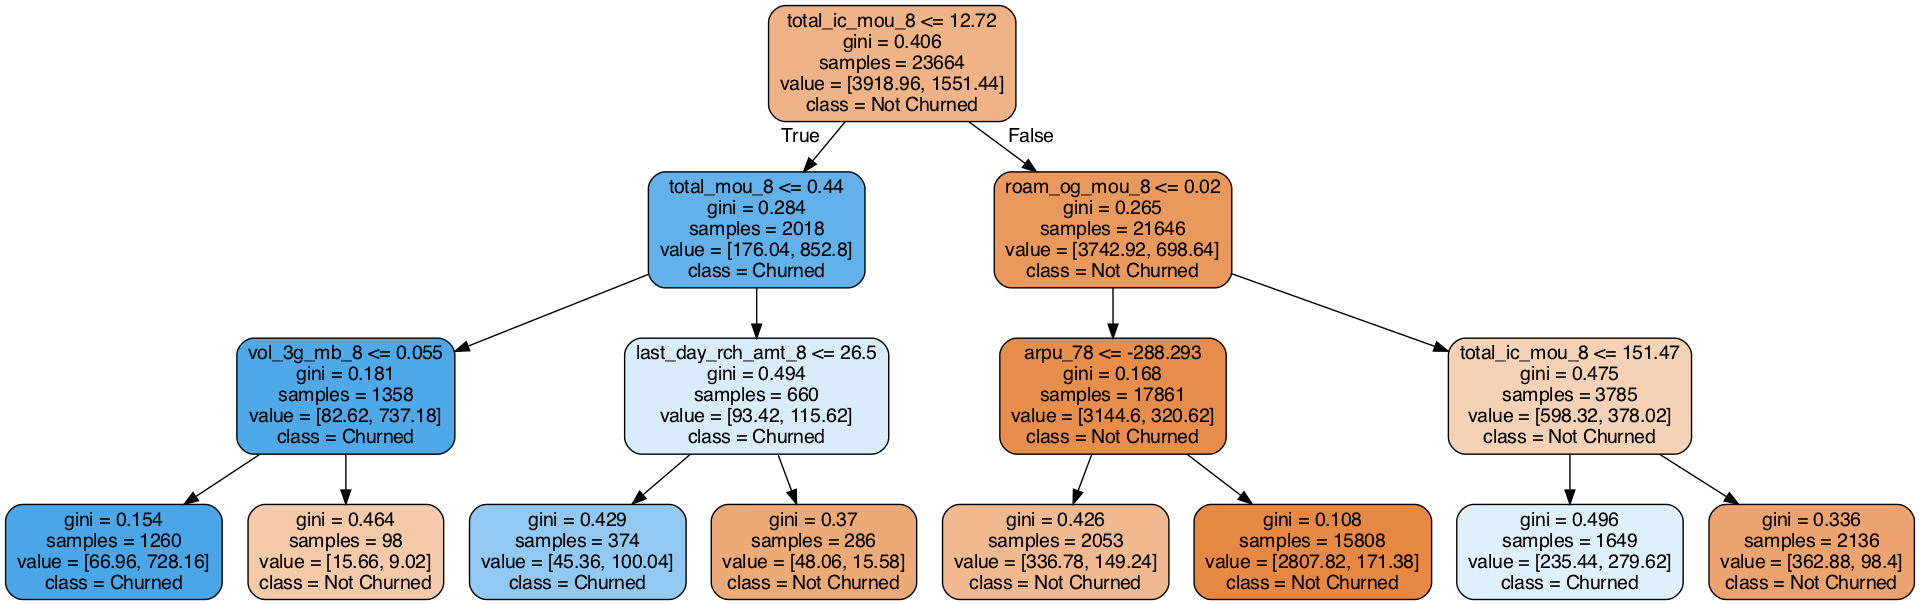

In [ ]:
print("Most important features or indicators of churn are", features_4)
Image(get_dt_graph(dt_best, X_train_4))

The important indicators of churn belong to the action phase (month 8) and last month of the good phase (month 7) and these are 
- total time spent in incoming calls in the action month
- total time spent in roaming outgoing calls in the action month
- difference of revenue between the last good month and the action month
- total time spent in all calls in the action month
- recharge amount on the last day in the action month
- volume of 3g data used in the action month

So the ```usage of calls and 3g data in the action month``` is a good indicator of whether a customer will churn or not

## Summary

In [ ]:
DF_SUMMARY

,Category,Num Features,Features,Accuracy,Sensitivity,Specificity,Precision,Recall,AUC
0,Logistic Regression - TRAIN - o.5 cut-off,11,"[std_og_mou_8, monthly_3g_8, total_ic_mou_8, t...",92.61,16.07,99.26,65.38,16.07,57.66
1,Logistic Regression - TRAIN - Optimum cut-off,11,"[std_og_mou_8, monthly_3g_8, total_ic_mou_8, t...",82.37,78.86,82.67,28.34,78.86,80.77
2,Logistic Regression - TEST,11,"[std_og_mou_8, monthly_3g_8, total_ic_mou_8, t...",82.44,78.65,82.77,28.40,78.65,80.71
3,Decision Tree - HPT - TRAIN,6,"[total_ic_mou_8, roam_og_mou_8, arpu_78, total...",89.55,71.41,91.13,41.15,71.41,81.27
4,Decision Tree - HPT - TEST,6,"[total_ic_mou_8, roam_og_mou_8, arpu_78, total...",89.54,68.08,91.40,40.76,68.08,79.74


In [ ]:
print(features_1)
print(features_4)

['std_og_mou_8', 'monthly_3g_8', 'total_ic_mou_8', 'total_rech_amt_6', 'monthly_2g_8', 'arpu_78', 'vol_mb_8', 'total_rech_num_8', 'last_day_rch_amt_8', 'sachet_2g_8', 'roam_og_mou_7']
['total_ic_mou_8', 'roam_og_mou_8', 'arpu_78', 'total_mou_8', 'last_day_rch_amt_8', 'vol_3g_mb_8']


# Recommend strategies to manage customer churn

In the action phase, ```identify``` the customers who are likely to churn using the ```indicators of churn``` - ['total_ic_mou_8', 'roam_og_mou_8', 'arpu_78', 'total_mou_8', 'last_day_rch_amt_8','vol_3g_mb_8'] and the following rules

If the total incoming mou < 12 minutes and 
- the total mou < .44 minutes and volume of 3g usage < 0.05 MB ```OR```
- the total mou > .44 minutes and recharge amount on the last day <= 26 units

then the customer is likely to churn

The customers usage drops significantly a month before they churn.So we can track the usage and apply below meeasurs to retain those customers.

```Take measures``` to retain these identified customers 

*   Offer discounts
*   Have the customer support talk to them to idenitfy and address issues that they may have
*   devise attractive special plans better than competitors  for these customers




- 
 - 